# Data Import

MISSING SWAPTION IV DATA: 97 dates
2000-12-25 (Monday)
2001-12-25 (Tuesday)
2002-02-11 (Monday)
2002-03-29 (Friday)
2005-04-14 (Thursday)
2006-11-02 (Thursday)
2006-11-13 (Monday)
2006-12-01 (Friday)
2006-12-12 (Tuesday)
2006-12-18 (Monday)
2006-12-19 (Tuesday)
2006-12-22 (Friday)
2007-01-08 (Monday)
2007-05-07 (Monday)
2007-08-27 (Monday)
2008-04-24 (Thursday)
2008-05-05 (Monday)
2008-05-26 (Monday)
2008-08-25 (Monday)
2008-09-17 (Wednesday)
2009-01-09 (Friday)
2009-05-19 (Tuesday)
2009-05-20 (Wednesday)
2009-05-25 (Monday)
2009-07-02 (Thursday)
2009-07-09 (Thursday)
2009-08-10 (Monday)
2009-08-21 (Friday)
2009-09-22 (Tuesday)
2009-09-29 (Tuesday)
2009-10-01 (Thursday)
2009-10-02 (Friday)
2009-12-28 (Monday)
2010-01-26 (Tuesday)
2010-02-17 (Wednesday)
2010-02-18 (Thursday)
2010-03-03 (Wednesday)
2010-05-21 (Friday)
2010-05-31 (Monday)
2010-06-22 (Tuesday)
2010-09-13 (Monday)
2010-09-16 (Thursday)
2010-09-17 (Friday)
2010-12-16 (Thursday)
2011-02-21 (Monday)
2011-04-29 (Friday)
2011-05

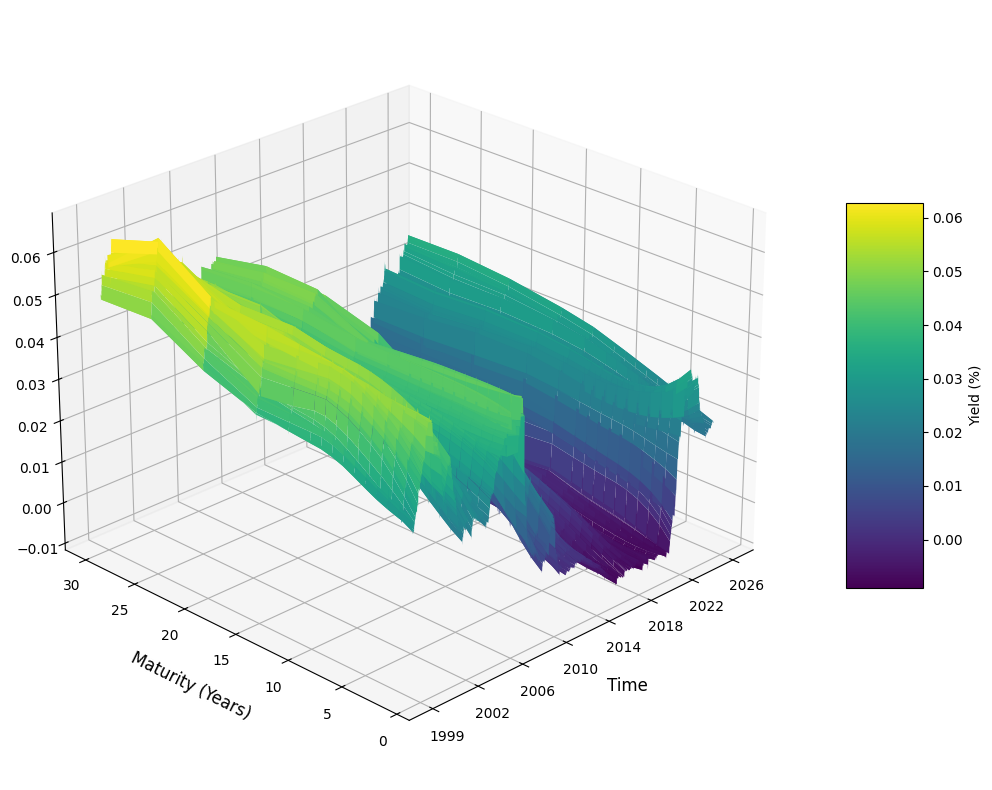


✓ 3D yield curve plot displayed for Germany (DE)


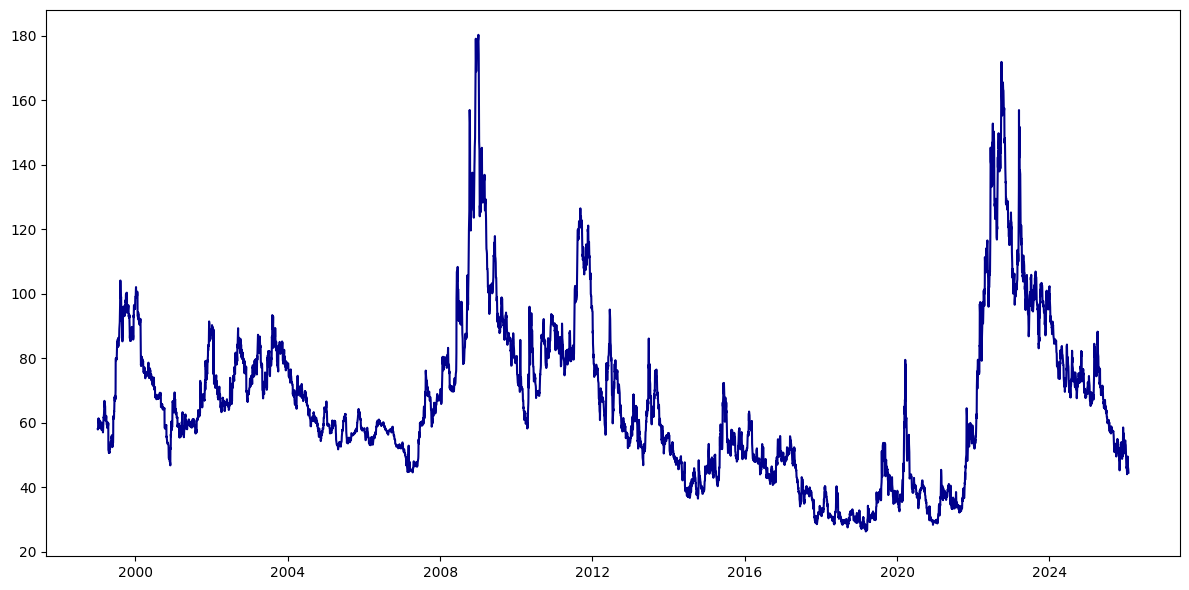


✓ Implied volatility plot displayed
✓ Dataset saved to: \\GIMECB01\HOMEDIR-VZ$\westenb\Thesis\Data\DE_YieldCurve_IV.csv


In [21]:
# ============================================
# IMPORT YIELD CURVE DATA AND ANALYSIS
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import os

# Define zero yield columns
zero_columns = ['ZERO_1Y', 'ZERO_2Y', 'ZERO_3Y', 'ZERO_4Y', 'ZERO_5Y', 
                'ZERO_6Y', 'ZERO_7Y', 'ZERO_8Y', 'ZERO_9Y', 'ZERO_10Y',
                'ZERO_12Y', 'ZERO_15Y', 'ZERO_20Y', 'ZERO_25Y', 'ZERO_30Y']

# ============================================
# 1. IMPORT DATA
# ============================================

# Define filepath as variable
filepath = r"\\GIMECB01\HOMEDIR-VZ$\westenb\Thesis\Data"
filename = "DE_YieldCurve.csv"
full_path = os.path.join(filepath, filename)

# Import CSV
df = pd.read_csv(full_path)
df['REFERENCE_DATE'] = pd.to_datetime(df['REFERENCE_DATE'], format='ISO8601')

# Drop weekends (Saturday=5, Sunday=6)
df = df[df['REFERENCE_DATE'].dt.dayofweek < 5].reset_index(drop=True)

# Import Swaption IV data
iv_filename = "Swaption_3M_IV.csv"
iv_full_path = os.path.join(filepath, iv_filename)
df_iv = pd.read_csv(iv_full_path)
df_iv['Date'] = pd.to_datetime(df_iv['Date'], format='%d/%m/%Y')

# Merge IV data onto yield curve data (left join to keep all yield curve dates)
df = df.merge(df_iv, left_on='REFERENCE_DATE', right_on='Date', how='left')
df = df.drop(columns=['Date'])  # Remove duplicate date column

# Print missing IV dates
missing_iv = df[df['IV'].isna()]['REFERENCE_DATE']
if len(missing_iv) > 0:
    print("="*80)
    print(f"MISSING SWAPTION IV DATA: {len(missing_iv)} dates")
    print("="*80)
    for date in missing_iv:
        print(date.strftime('%Y-%m-%d (%A)'))
    print()

# Interpolate missing IV values linearly
df['IV'] = df['IV'].interpolate(method='linear', limit_direction='both')

# Check and interpolate any missing values in yield columns  
missing_yields = df[zero_columns].isnull().sum()
if missing_yields.any():
    print("="*80)
    print("MISSING YIELD DATA DETECTED - APPLYING LINEAR INTERPOLATION")
    print("="*80)
    print(missing_yields[missing_yields > 0])
    print()
    df[zero_columns] = df[zero_columns].interpolate(method='linear', limit_direction='both')



print("="*80)
print("YIELD CURVE DATA IMPORTED: GERMANY (DE)")
print("="*80)
print(f"File: {filename}")
print(f"Rows: {len(df)} (weekends excluded)")
print(f"Date range: {df['REFERENCE_DATE'].min().date()} to {df['REFERENCE_DATE'].max().date()}")
print(f"IV observations: {df['IV'].notna().sum()} ({df['IV'].notna().sum()/len(df)*100:.1f}%)")
print()



# ============================================
# 2. SUMMARY STATISTICS (ACADEMIC FORMAT)
# ============================================



# Add IV to statistics
stats_columns = zero_columns + ['IV']

# Calculate statistics
stats_df = pd.DataFrame({
    'Mean': df[stats_columns].mean(),
    'Std': df[stats_columns].std(),
    'Min': df[stats_columns].min(),
    'Q25': df[stats_columns].quantile(0.25),
    'Median': df[stats_columns].median(),
    'Q75': df[stats_columns].quantile(0.75),
    'Max': df[stats_columns].max(),
    'N': df[stats_columns].count()
})

print("="*80)
print("TABLE: SUMMARY STATISTICS OF ZERO-COUPON YIELD CURVES AND IMPLIED VOLATILITY")
print("="*80)
print("Market: Germany (DE)")
print(f"Sample period: {df['REFERENCE_DATE'].min().date()} to {df['REFERENCE_DATE'].max().date()}")
print(f"Observations: {len(df)}")
print()
print("All values in percentage points (%)")
print("-"*80)
print(stats_df.round(3).to_string())
print("="*80)
print()

# Additional statistics
print("ADDITIONAL STATISTICS")
print("-"*80)
print(f"Time series length: {len(df)} observations")
print(f"Total observation period: {(df['REFERENCE_DATE'].max() - df['REFERENCE_DATE'].min()).days} days")
print(f"Average observation frequency: {(df['REFERENCE_DATE'].max() - df['REFERENCE_DATE'].min()).days / len(df):.2f} days")
print()

# ============================================
# 3. 3D YIELD CURVE PLOT
# ============================================

# Create plotting copy with complete date range for smooth visualization
df_plot = df.copy()
date_range_plot = pd.bdate_range(start=df_plot['REFERENCE_DATE'].min(), 
                                  end=df_plot['REFERENCE_DATE'].max())
df_plot = df_plot.set_index('REFERENCE_DATE').reindex(date_range_plot)
df_plot[zero_columns] = df_plot[zero_columns].interpolate(method='cubic')  # Cubic for smoother
df_plot = df_plot.reset_index().rename(columns={'index': 'REFERENCE_DATE'})

# Prepare data for 3D plot
dates = df_plot['REFERENCE_DATE'].values
maturities = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]

# Create meshgrid
date_nums = np.arange(len(dates))
X, Y = np.meshgrid(date_nums, maturities)

# Create Z matrix (yields)
Z = df_plot[zero_columns].T.values
#
# Create 3D plot
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Surface plot with enhanced smoothing
surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, 
                       linewidth=0, antialiased=True, alpha=1,
                       rcount=500, ccount=500,  # Higher = smoother
                       shade=True, lightsource=None)

# Labels
ax.set_xlabel('Time', fontsize=12, labelpad=10)
ax.set_ylabel('Maturity (Years)', fontsize=12, labelpad=10)
ax.set_zlabel('Zero Yield (%)', fontsize=12, labelpad=10)

# Set x-axis ticks to show only years
num_ticks = 8
tick_positions = np.linspace(0, len(dates)-1, num_ticks, dtype=int)
ax.set_xticks(tick_positions)
ax.set_xticklabels([pd.Timestamp(dates[i]).year for i in tick_positions], 
                    rotation=0, ha='center', fontsize=10)

# Colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Yield (%)')

# Adjust viewing angle
ax.view_init(elev=25, azim=225)

plt.tight_layout()
plt.show()

print("\n✓ 3D yield curve plot displayed for Germany (DE)")

# ============================================
# 4. IMPLIED VOLATILITY PLOT
# ============================================

# Filter data with non-null IV values
df_iv_plot = df[df['IV'].notna()]

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_iv_plot['REFERENCE_DATE'], df_iv_plot['IV'], color='darkblue', linewidth=1.5)
ax.grid(False)
plt.tight_layout()
plt.show()

print("\n✓ Implied volatility plot displayed")

# Save merged dataframe with IV
output_filename = "DE_YieldCurve_IV.csv"
output_path = os.path.join(filepath, output_filename)
df.to_csv(output_path, index=False)
print(f"✓ Dataset saved to: {output_path}")

# Yield Curve fitting for training purpouses

## PCA levels

In [6]:
# ============================================
# CREATE PCA TRAINING MATRIX FOR ANN (LEVELS)
# Using fixed lookback with future forecasts
# ============================================

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import os


print("="*80)
print("CREATING PCA TRAINING MATRIX ON LEVELS (df_pca)")
print("="*80)

# ============================================
# PARAMETERS
# ============================================

lookback = 756  # 3 years * 252 trading days
future = 21     # ~1 month in trading days
n_factors = 4   # Number of principal components

print(f"\nParameters:")
print(f"  Lookback window: {lookback} trading days ({lookback/252:.2f} years)")
print(f"  Forecast horizon: {future} trading days (~1 month)")
print(f"  Number of factors: {n_factors}")

# ============================================
# INITIALIZE STORAGE
# ============================================

# Define zero yield columns
zero_columns = ['ZERO_1Y', 'ZERO_2Y', 'ZERO_3Y', 'ZERO_4Y', 'ZERO_5Y', 
                'ZERO_6Y', 'ZERO_7Y', 'ZERO_8Y', 'ZERO_9Y', 'ZERO_10Y',
                'ZERO_12Y', 'ZERO_15Y', 'ZERO_20Y', 'ZERO_25Y', 'ZERO_30Y']

# Column names for loadings (15 maturities × n_factors PCs)
maturity_names = ['1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', 
                  '12Y', '15Y', '20Y', '25Y', '30Y']
loading_columns = []
for mat in maturity_names:
    for pc in range(1, n_factors + 1):
        loading_columns.append(f'L_{mat}_PC{pc}')

# Factor column names
current_factor_cols = [f'CURRENT_PC{i}' for i in range(1, n_factors + 1)]
future_factor_cols = [f'FUTURE_PC{i}' for i in range(1, n_factors + 1)]

# Eigenvalue column names
eigenval_cols = [f'EIGENVAL_{i}' for i in range(1, n_factors + 1)]

# All column names
columns = (
    ['CURRENT_DATE', 'FORECASTED_DATE'] +
    eigenval_cols +
    loading_columns +
    current_factor_cols + ['RMSE_CURRENT', 'MAE_CURRENT', 'TAE_CURRENT'] +
    future_factor_cols + ['RMSE_FUTURE', 'MAE_FUTURE', 'TAE_FUTURE']
)

# Initialize list to store rows
data_rows = []

print(f"\nTotal columns in df_pca: {len(columns)}")
print(f"  - 2 date columns")
print(f"  - {n_factors} eigenvalue columns")
print(f"  - {len(loading_columns)} loading columns (15 maturities × {n_factors} PCs)")
print(f"  - {n_factors + 3} current state columns ({n_factors} factors + RMSE + MAE + TAE)")
print(f"  - {n_factors + 3} future state columns ({n_factors} factors + RMSE + MAE + TAE)")

# ============================================
# GENERATE TRAINING MATRIX
# ============================================

print(f"\n{'='*80}")
print("GENERATING OBSERVATIONS...")
print("="*80)

# Starting index: need lookback history
start_idx = lookback

# Ending index: need future data available
end_idx = len(df) - future

n_observations = end_idx - start_idx

print(f"\nProcessing {n_observations} observations...")
print(f"  Start index: {start_idx} (date: {df.iloc[start_idx]['REFERENCE_DATE'].date()})")
print(f"  End index: {end_idx} (date: {df.iloc[end_idx]['REFERENCE_DATE'].date()})")
print(f"  Last forecast date: {df.iloc[end_idx + future - 1]['REFERENCE_DATE'].date()}")

# Progress tracking
progress_interval = max(1, n_observations // 10)

for i in range(start_idx, end_idx):
    # Progress indicator
    if (i - start_idx) % progress_interval == 0:
        progress = ((i - start_idx) / n_observations) * 100
        print(f"  Progress: {progress:.0f}% (observation {i-start_idx+1}/{n_observations})")
    
    # ============================================
    # 1. DEFINE DATES
    # ============================================
    
    current_idx = i
    future_idx = i + future
    
    current_date = df.iloc[current_idx]['REFERENCE_DATE']
    forecasted_date = df.iloc[future_idx]['REFERENCE_DATE']
    
    # ============================================
    # 2. ESTIMATE PCA ON LOOKBACK WINDOW
    # ============================================
    
    # Window: [current_idx - lookback : current_idx]
    window_start = current_idx - lookback
    window_end = current_idx
    
    Y_window = df.iloc[window_start:window_end][zero_columns].values
    
    # Fit PCA
    pca = PCA(n_components=n_factors)
    pca.fit(Y_window)
    
    # Get eigenvalues
    eigenvalues = pca.explained_variance_
    
    # Get loadings (15 × n_factors matrix)
    loadings = pca.components_.T  # Transpose to get (15 × n_factors)
    
    # Flatten loadings for storage (row-major order)
    loadings_flat = loadings.flatten()  # 15 * n_factors values
    
    # ============================================
    # 3. CURRENT STATE (using current loadings)
    # ============================================
    
    # Get current yield curve
    y_current = df.iloc[current_idx][zero_columns].values.reshape(1, -1)  # (1 × 15)
    
    # Calculate current factors: f = y @ L
    factors_current = y_current @ loadings  # (1 × n_factors)
    factors_current = factors_current.flatten()
    
    # Reconstruct current yield curve
    y_current_reconstructed = factors_current @ loadings.T  # (1 × 15)
    
    # Calculate errors
    errors_current = y_current.flatten() - y_current_reconstructed
    rmse_current = np.sqrt(np.mean(errors_current**2))
    mae_current = np.mean(np.abs(errors_current))
    tae_current = np.sum(np.abs(errors_current))
    
    # ============================================
    # 4. FUTURE STATE (using SAME loadings)
    # ============================================
    
    # Get future yield curve
    y_future = df.iloc[future_idx][zero_columns].values.reshape(1, -1)  # (1 × 15)
    
    # Calculate future factors using CURRENT loadings: f = y @ L_current
    factors_future = y_future @ loadings  # (1 × n_factors)
    factors_future = factors_future.flatten()
    
    # Reconstruct future yield curve using CURRENT loadings
    y_future_reconstructed = factors_future @ loadings.T  # (1 × 15)
    
    # Calculate errors
    errors_future = y_future.flatten() - y_future_reconstructed
    rmse_future = np.sqrt(np.mean(errors_future**2))
    mae_future = np.mean(np.abs(errors_future))
    tae_future = np.sum(np.abs(errors_future))
    
    # ============================================
    # 5. STORE ROW
    # ============================================
    
    row = [
        current_date,
        forecasted_date,
        *eigenvalues,  # 4 eigenvalue values
        *loadings_flat,  # 15 * n_factors loading values
        *factors_current,  # n_factors current factor values
        rmse_current, mae_current, tae_current,
        *factors_future,  # n_factors future factor values
        rmse_future, mae_future, tae_future
    ]
    
    data_rows.append(row)

# ============================================
# CREATE DATAFRAME
# ============================================

print(f"\n{'='*80}")
print("CREATING DATAFRAME...")
print("="*80)

df_pca = pd.DataFrame(data_rows, columns=columns)

print(f"\n✓ df_pca created successfully!")
print(f"  Shape: {df_pca.shape}")
print(f"  Columns: {len(df_pca.columns)}")
print(f"  Rows: {len(df_pca)}")

# ============================================
# CALCULATE PROPER RATIOS (FRESH vs STALE)
# ============================================

print(f"\n{'='*80}")
print("CALCULATING LOADING STABILITY RATIOS")
print("="*80)
print("\nComparing fresh loadings (L_t+h) vs stale loadings (L_t) for same yield curve at t+h")

# Initialize ratio columns with NaN
df_pca['RMSE_RATIO'] = np.nan
df_pca['MAE_RATIO'] = np.nan
df_pca['TAE_RATIO'] = np.nan

# For each row, find the corresponding "fresh" loadings row
ratio_count = 0
for idx in range(len(df_pca)):
    forecasted_date = df_pca.iloc[idx]['FORECASTED_DATE']
    
    # Find row where CURRENT_DATE equals this FORECASTED_DATE
    # This gives us the "fresh" loadings for that date
    fresh_row = df_pca[df_pca['CURRENT_DATE'] == forecasted_date]
    
    if len(fresh_row) > 0:
        fresh_row = fresh_row.iloc[0]
        
        # Calculate ratios: stale (FUTURE from current row) / fresh (CURRENT from matched row)
        rmse_ratio = df_pca.iloc[idx]['RMSE_FUTURE'] / fresh_row['RMSE_CURRENT']
        mae_ratio = df_pca.iloc[idx]['MAE_FUTURE'] / fresh_row['MAE_CURRENT']
        tae_ratio = df_pca.iloc[idx]['TAE_FUTURE'] / fresh_row['TAE_CURRENT']
        
        # Store ratios
        df_pca.at[idx, 'RMSE_RATIO'] = rmse_ratio
        df_pca.at[idx, 'MAE_RATIO'] = mae_ratio
        df_pca.at[idx, 'TAE_RATIO'] = tae_ratio
        
        ratio_count += 1

print(f"\n✓ Calculated ratios for {ratio_count} observations")
print(f"  Missing ratios (first {future} observations): {len(df_pca) - ratio_count}")

# ============================================
# SUMMARY STATISTICS
# ============================================

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print("="*80)

print(f"\nDate Range:")
print(f"  First current date: {df_pca['CURRENT_DATE'].min().date()}")
print(f"  Last current date: {df_pca['CURRENT_DATE'].max().date()}")
print(f"  First forecast date: {df_pca['FORECASTED_DATE'].min().date()}")
print(f"  Last forecast date: {df_pca['FORECASTED_DATE'].max().date()}")

print(f"\nEigenvalue Statistics:")
eigenval_stats = df_pca[eigenval_cols].describe()
print(eigenval_stats)

print(f"\nFactor Statistics (Current):")
factor_stats_current = df_pca[current_factor_cols].describe()
print(factor_stats_current.round(4))

print(f"\nFactor Statistics (Future):")
factor_stats_future = df_pca[future_factor_cols].describe()
print(factor_stats_future.round(4))

print(f"\nError Statistics (Current - Fresh Loadings):")
error_stats_current = df_pca[['RMSE_CURRENT', 'MAE_CURRENT', 'TAE_CURRENT']].describe()
print(error_stats_current)

print(f"\nError Statistics (Future - Stale Loadings):")
error_stats_future = df_pca[['RMSE_FUTURE', 'MAE_FUTURE', 'TAE_FUTURE']].describe()
print(error_stats_future)

print(f"\n{'='*80}")
print("TESTING L_t ≈ L_t+h ASSUMPTION (LEVELS)")
print("="*80)
print("\nComparing same yield curve reconstructed with fresh vs stale loadings")

# Summary statistics for ratios (excluding NaN)
ratio_stats = df_pca[['RMSE_RATIO', 'MAE_RATIO', 'TAE_RATIO']].describe()
print(f"\nRatio Statistics (Stale/Fresh):")
print(ratio_stats)

# Detailed interpretation for each metric
for metric in ['RMSE', 'MAE', 'TAE']:
    ratio_col = f'{metric}_RATIO'
    mean_ratio = df_pca[ratio_col].mean()
    median_ratio = df_pca[ratio_col].median()
    
    print(f"\n{metric} Ratio Analysis:")
    print(f"  Mean: {mean_ratio:.4f} (stale loadings increase {metric} by {(mean_ratio-1)*100:.1f}%)")
    print(f"  Median: {median_ratio:.4f} (stale loadings increase {metric} by {(median_ratio-1)*100:.1f}%)")
    
    if mean_ratio < 1.1:
        print(f"  ✓✓✓ EXCELLENT: Loading stability assumption is VALID")
    elif mean_ratio < 1.5:
        print(f"  ✓ ACCEPTABLE: Loading stability assumption is reasonable")
    else:
        print(f"  ✗ CONCERNING: Loading stability assumption may be questionable")

# ============================================
# SAVE TO CSV
# ============================================

print(f"\n{'='*80}")
print("SAVING df_pca TO CSV")
print("="*80)

save_path = r"\\GIMECB01\HOMEDIR-VZ$\westenb\Thesis\Data"
filename = "PCA_fit.csv"
full_path = os.path.join(save_path, filename)

df_pca.to_csv(full_path, index=False)

print(f"\n✓ Saved: {filename}")
print(f"  Location: {save_path}")
print(f"  Rows: {len(df_pca)}")
print(f"  Columns: {len(df_pca.columns)}")

print(f"\n{'='*80}")
print("df_pca READY FOR ANN TRAINING")
print("="*80)

# Display first few rows
print(f"\nFirst 5 rows (selected columns):")
display_cols = (['CURRENT_DATE', 'FORECASTED_DATE'] + 
                eigenval_cols +
                current_factor_cols + ['RMSE_CURRENT', 'MAE_CURRENT', 'TAE_CURRENT'] +
                future_factor_cols + ['RMSE_FUTURE', 'MAE_FUTURE', 'TAE_FUTURE'] +
                ['RMSE_RATIO', 'MAE_RATIO', 'TAE_RATIO'])
print(df_pca[display_cols].head())

print(f"\n✓ Levels-based PCA matrix generation complete!")

CREATING PCA TRAINING MATRIX ON LEVELS (df_pca)

Parameters:
  Lookback window: 756 trading days (3.00 years)
  Forecast horizon: 21 trading days (~1 month)
  Number of factors: 4

Total columns in df_pca: 80
  - 2 date columns
  - 4 eigenvalue columns
  - 60 loading columns (15 maturities × 4 PCs)
  - 7 current state columns (4 factors + RMSE + MAE + TAE)
  - 7 future state columns (4 factors + RMSE + MAE + TAE)

GENERATING OBSERVATIONS...

Processing 6183 observations...
  Start index: 756 (date: 2001-11-27)
  End index: 6939 (date: 2025-12-31)
  Last forecast date: 2026-01-28
  Progress: 0% (observation 1/6183)
  Progress: 10% (observation 619/6183)
  Progress: 20% (observation 1237/6183)
  Progress: 30% (observation 1855/6183)
  Progress: 40% (observation 2473/6183)
  Progress: 50% (observation 3091/6183)
  Progress: 60% (observation 3709/6183)
  Progress: 70% (observation 4327/6183)
  Progress: 80% (observation 4945/6183)
  Progress: 90% (observation 5563/6183)
  Progress: 100% (o

## PCA changes

In [7]:
# ============================================
# COMPLETE YIELD CURVE CHANGES AND PCA ANALYSIS
# FIXED: Now uses 21-day CUMULATIVE changes for forecasting
# ============================================

import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA

# ============================================
# 2. CREATE YIELD CURVE CHANGES DATASET
# ============================================

print("\n" + "="*80)
print("CREATING YIELD CURVE CHANGES DATASET")
print("="*80)

# Define zero yield columns
zero_columns = ['ZERO_1Y', 'ZERO_2Y', 'ZERO_3Y', 'ZERO_4Y', 'ZERO_5Y', 
                'ZERO_6Y', 'ZERO_7Y', 'ZERO_8Y', 'ZERO_9Y', 'ZERO_10Y',
                'ZERO_12Y', 'ZERO_15Y', 'ZERO_20Y', 'ZERO_25Y', 'ZERO_30Y']

# CRITICAL: Start with a COPY of df to avoid any issues
df_changes = df.copy()

# Calculate changes IN PLACE on the copied dataframe
for col in zero_columns:
    df_changes[col] = df_changes[col].diff()

# Calculate change for IV
df_changes['IV'] = df_changes['IV'].diff()

# Check for any unexpected NaN values before dropping first row
print(f"\nBefore dropping first row:")
print(f"  Total rows: {len(df_changes)}")
print(f"  NaN count per column:")
for col in zero_columns + ['IV']:
    nan_count = df_changes[col].isna().sum()
    if nan_count > 1:  # Should only be 1 NaN (first row)
        print(f"    ⚠ WARNING: {col} has {nan_count} NaN values (expected 1)")

# Drop ONLY the first row (which has NaN from diff)
df_changes = df_changes.iloc[1:].reset_index(drop=True)

print(f"\n✓ Changes calculated successfully!")
print(f"  Original df rows: {len(df)}")
print(f"  df_changes rows: {len(df_changes)} (1 row dropped)")
print(f"  Expected: {len(df) - 1}")

# Verify no rows lost unexpectedly
if len(df_changes) != len(df) - 1:
    print(f"  ⚠ WARNING: Expected {len(df) - 1} rows but got {len(df_changes)}")
    print(f"  Missing {len(df) - 1 - len(df_changes)} rows!")
else:
    print(f"  ✓ Correct number of rows!")

print(f"  Date range: {df_changes['REFERENCE_DATE'].min().date()} to {df_changes['REFERENCE_DATE'].max().date()}")

# Check for any remaining NaN values
nan_check = df_changes[zero_columns + ['IV']].isna().sum()
if nan_check.sum() > 0:
    print(f"\n⚠ WARNING: NaN values found after dropping first row:")
    print(nan_check[nan_check > 0])

# Display summary statistics
print(f"\nChange Statistics (first 3 maturities):")
for col in zero_columns[:3]:
    print(f"  {col}: mean={df_changes[col].mean():.6f}, std={df_changes[col].std():.6f}")
print(f"  IV: mean={df_changes['IV'].mean():.6f}, std={df_changes['IV'].std():.6f}")

# Save to CSV
save_path = filepath
filename_changes = "DE_YieldCurve_Changes.csv"
full_path_changes = os.path.join(save_path, filename_changes)

df_changes.to_csv(full_path_changes, index=False)

print(f"\n✓ Saved: {filename_changes}")
print(f"  Location: {save_path}")
print(f"  Rows: {len(df_changes)}")
print(f"  Columns: {len(df_changes.columns)}")

# ============================================
# 4. CREATE PCA TRAINING MATRIX ON CUMULATIVE CHANGES
# ============================================

print("\n" + "="*80)
print("CREATING PCA TRAINING MATRIX ON CUMULATIVE CHANGES (df_pca_changes)")
print("="*80)
print("\n⚠ IMPORTANT: Using 21-day CUMULATIVE changes for forecasting")
print("   PCA fitted on daily changes, but factors extracted for cumulative changes")

# ============================================
# PARAMETERS
# ============================================

lookback = 756  # 3 years * 252 trading days
future = 21     # ~1 month in trading days
n_factors = 4   # Number of principal components

print(f"\nParameters:")
print(f"  Lookback window: {lookback} trading days ({lookback/252:.2f} years)")
print(f"  Forecast horizon: {future} trading days (~1 month)")
print(f"  Number of factors: {n_factors}")

# ============================================
# INITIALIZE STORAGE
# ============================================

# Column names for loadings (15 maturities × n_factors PCs)
maturity_names = ['1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', 
                  '12Y', '15Y', '20Y', '25Y', '30Y']
loading_columns = []
for mat in maturity_names:
    for pc in range(1, n_factors + 1):
        loading_columns.append(f'L_{mat}_PC{pc}')

# Factor column names
current_factor_cols = [f'CURRENT_PC{i}' for i in range(1, n_factors + 1)]
future_factor_cols = [f'FUTURE_PC{i}' for i in range(1, n_factors + 1)]

# Eigenvalue column names
eigenval_cols = [f'EIGENVAL_{i}' for i in range(1, n_factors + 1)]

# All column names
columns = (
    ['CURRENT_DATE', 'FORECASTED_DATE'] +
    eigenval_cols +
    loading_columns +
    current_factor_cols + ['RMSE_CURRENT', 'MAE_CURRENT', 'TAE_CURRENT'] +
    future_factor_cols + ['RMSE_FUTURE', 'MAE_FUTURE', 'TAE_FUTURE']
)

# Initialize list to store rows
data_rows = []

print(f"\nTotal columns in df_pca_changes: {len(columns)}")
print(f"  - 2 date columns")
print(f"  - {n_factors} eigenvalue columns")
print(f"  - {len(loading_columns)} loading columns (15 maturities × {n_factors} PCs)")
print(f"  - {n_factors + 3} current state columns ({n_factors} factors + RMSE + MAE + TAE)")
print(f"  - {n_factors + 3} future state columns ({n_factors} factors + RMSE + MAE + TAE)")

# ============================================
# GENERATE TRAINING MATRIX
# ============================================

print(f"\n{'='*80}")
print("GENERATING OBSERVATIONS...")
print("="*80)

# Starting index: need lookback history + future for current cumulative change
start_idx = lookback + future

# Ending index: need future data available
end_idx = len(df_changes) - future

n_observations = end_idx - start_idx

print(f"\nProcessing {n_observations} observations...")
print(f"  Start index: {start_idx} (date: {df_changes.iloc[start_idx]['REFERENCE_DATE'].date()})")
print(f"  End index: {end_idx} (date: {df_changes.iloc[end_idx]['REFERENCE_DATE'].date()})")
print(f"  Last forecast date: {df_changes.iloc[end_idx + future - 1]['REFERENCE_DATE'].date()}")

# Progress tracking
progress_interval = max(1, n_observations // 10)

for i in range(start_idx, end_idx):
    # Progress indicator
    if (i - start_idx) % progress_interval == 0:
        progress = ((i - start_idx) / n_observations) * 100
        print(f"  Progress: {progress:.0f}% (observation {i-start_idx+1}/{n_observations})")
    
    # ============================================
    # 1. DEFINE DATES
    # ============================================
    
    current_idx = i
    future_idx = i + future
    
    current_date = df_changes.iloc[current_idx]['REFERENCE_DATE']
    forecasted_date = df_changes.iloc[future_idx]['REFERENCE_DATE']
    
    # ============================================
    # 2. ESTIMATE PCA ON LOOKBACK WINDOW (DAILY CHANGES)
    # ============================================
    
    # Window: [current_idx - lookback : current_idx]
    window_start = current_idx - lookback
    window_end = current_idx
    
    Y_window = df_changes.iloc[window_start:window_end][zero_columns].values
    
    # Fit PCA on daily changes
    pca = PCA(n_components=n_factors)
    pca.fit(Y_window)
    
    # Get eigenvalues
    eigenvalues = pca.explained_variance_
    
    # Get loadings (15 × n_factors matrix)
    loadings = pca.components_.T  # Transpose to get (15 × n_factors)
    
    # Flatten loadings for storage (row-major order)
    loadings_flat = loadings.flatten()  # 15 * n_factors values
    
    # ============================================
    # 3. CURRENT STATE (21-day CUMULATIVE change ending at t)
    # ============================================
    
    # Get levels from original df (adjust index: df_changes index i → df index i+1)
    past_idx_in_df = (current_idx - future) + 1  # t-21 in df coordinates
    current_idx_in_df = current_idx + 1          # t in df coordinates
    
    y_past_level = df.iloc[past_idx_in_df][zero_columns].values
    y_current_level = df.iloc[current_idx_in_df][zero_columns].values
    
    # Cumulative change from t-21 to t
    cumulative_change_current = y_current_level - y_past_level
    y_current = cumulative_change_current.reshape(1, -1)  # (1 × 15)
    
    # Calculate current factors: f = y @ L
    factors_current = y_current @ loadings  # (1 × n_factors)
    factors_current = factors_current.flatten()
    
    # Reconstruct current cumulative change
    y_current_reconstructed = factors_current @ loadings.T  # (1 × 15)
    
    # Calculate errors
    errors_current = y_current.flatten() - y_current_reconstructed
    rmse_current = np.sqrt(np.mean(errors_current**2))
    mae_current = np.mean(np.abs(errors_current))
    tae_current = np.sum(np.abs(errors_current))
    
    # ============================================
    # 4. FUTURE STATE (21-day CUMULATIVE change from t to t+21)
    # ============================================
    
    # Get levels from original df
    future_idx_in_df = future_idx + 1  # t+21 in df coordinates
    
    y_future_level = df.iloc[future_idx_in_df][zero_columns].values
    
    # Cumulative change from t to t+21
    cumulative_change_future = y_future_level - y_current_level
    y_future = cumulative_change_future.reshape(1, -1)  # (1 × 15)
    
    # Calculate future factors using CURRENT loadings: f = y @ L_current
    factors_future = y_future @ loadings  # (1 × n_factors)
    factors_future = factors_future.flatten()
    
    # Reconstruct future cumulative change using CURRENT loadings
    y_future_reconstructed = factors_future @ loadings.T  # (1 × 15)
    
    # Calculate errors
    errors_future = y_future.flatten() - y_future_reconstructed
    rmse_future = np.sqrt(np.mean(errors_future**2))
    mae_future = np.mean(np.abs(errors_future))
    tae_future = np.sum(np.abs(errors_future))
    
    # ============================================
    # 5. STORE ROW
    # ============================================
    
    row = [
        current_date,
        forecasted_date,
        *eigenvalues,  # 4 eigenvalue values
        *loadings_flat,  # 15 * n_factors loading values
        *factors_current,  # n_factors current factor values
        rmse_current, mae_current, tae_current,
        *factors_future,  # n_factors future factor values
        rmse_future, mae_future, tae_future
    ]
    
    data_rows.append(row)

# ============================================
# CREATE DATAFRAME
# ============================================

print(f"\n{'='*80}")
print("CREATING DATAFRAME...")
print("="*80)

df_pca_changes = pd.DataFrame(data_rows, columns=columns)

print(f"\n✓ df_pca_changes created successfully!")
print(f"  Shape: {df_pca_changes.shape}")
print(f"  Columns: {len(df_pca_changes.columns)}")
print(f"  Rows: {len(df_pca_changes)}")

# ============================================
# CALCULATE PROPER RATIOS (FRESH vs STALE)
# ============================================

print(f"\n{'='*80}")
print("CALCULATING LOADING STABILITY RATIOS")
print("="*80)
print("\nComparing fresh loadings (L_t+h) vs stale loadings (L_t) for same cumulative change at t+h")

# Initialize ratio columns with NaN
df_pca_changes['RMSE_RATIO'] = np.nan
df_pca_changes['MAE_RATIO'] = np.nan
df_pca_changes['TAE_RATIO'] = np.nan

# For each row, find the corresponding "fresh" loadings row
ratio_count = 0
for idx in range(len(df_pca_changes)):
    forecasted_date = df_pca_changes.iloc[idx]['FORECASTED_DATE']
    
    # Find row where CURRENT_DATE equals this FORECASTED_DATE
    fresh_row = df_pca_changes[df_pca_changes['CURRENT_DATE'] == forecasted_date]
    
    if len(fresh_row) > 0:
        fresh_row = fresh_row.iloc[0]
        
        # Calculate ratios: stale (FUTURE from current row) / fresh (CURRENT from matched row)
        rmse_ratio = df_pca_changes.iloc[idx]['RMSE_FUTURE'] / fresh_row['RMSE_CURRENT']
        mae_ratio = df_pca_changes.iloc[idx]['MAE_FUTURE'] / fresh_row['MAE_CURRENT']
        tae_ratio = df_pca_changes.iloc[idx]['TAE_FUTURE'] / fresh_row['TAE_CURRENT']
        
        # Store ratios
        df_pca_changes.at[idx, 'RMSE_RATIO'] = rmse_ratio
        df_pca_changes.at[idx, 'MAE_RATIO'] = mae_ratio
        df_pca_changes.at[idx, 'TAE_RATIO'] = tae_ratio
        
        ratio_count += 1

print(f"\n✓ Calculated ratios for {ratio_count} observations")
print(f"  Missing ratios (first {future} observations): {len(df_pca_changes) - ratio_count}")

# ============================================
# SUMMARY STATISTICS
# ============================================

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print("="*80)

print(f"\nDate Range:")
print(f"  First current date: {df_pca_changes['CURRENT_DATE'].min().date()}")
print(f"  Last current date: {df_pca_changes['CURRENT_DATE'].max().date()}")
print(f"  First forecast date: {df_pca_changes['FORECASTED_DATE'].min().date()}")
print(f"  Last forecast date: {df_pca_changes['FORECASTED_DATE'].max().date()}")

print(f"\nEigenvalue Statistics:")
eigenval_stats = df_pca_changes[eigenval_cols].describe()
print(eigenval_stats)

print(f"\nFactor Statistics (Current - 21-day cumulative):")
factor_stats_current = df_pca_changes[current_factor_cols].describe()
print(factor_stats_current.round(6))

print(f"\nFactor Statistics (Future - 21-day cumulative):")
factor_stats_future = df_pca_changes[future_factor_cols].describe()
print(factor_stats_future.round(6))

print(f"\nError Statistics (Current - Fresh Loadings):")
error_stats_current = df_pca_changes[['RMSE_CURRENT', 'MAE_CURRENT', 'TAE_CURRENT']].describe()
print(error_stats_current)

print(f"\nError Statistics (Future - Stale Loadings):")
error_stats_future = df_pca_changes[['RMSE_FUTURE', 'MAE_FUTURE', 'TAE_FUTURE']].describe()
print(error_stats_future)

print(f"\n{'='*80}")
print("TESTING L_t ≈ L_t+h ASSUMPTION (CUMULATIVE CHANGES)")
print("="*80)
print("\nComparing same 21-day cumulative change reconstructed with fresh vs stale loadings")

# Summary statistics for ratios (excluding NaN)
ratio_stats = df_pca_changes[['RMSE_RATIO', 'MAE_RATIO', 'TAE_RATIO']].describe()
print(f"\nRatio Statistics (Stale/Fresh):")
print(ratio_stats)

# Detailed interpretation for each metric
for metric in ['RMSE', 'MAE', 'TAE']:
    ratio_col = f'{metric}_RATIO'
    mean_ratio = df_pca_changes[ratio_col].mean()
    median_ratio = df_pca_changes[ratio_col].median()
    
    print(f"\n{metric} Ratio Analysis:")
    print(f"  Mean: {mean_ratio:.4f} (stale loadings increase {metric} by {(mean_ratio-1)*100:.1f}%)")
    print(f"  Median: {median_ratio:.4f} (stale loadings increase {metric} by {(median_ratio-1)*100:.1f}%)")
    
    if mean_ratio < 1.1:
        print(f"  ✓✓✓ EXCELLENT: Loading stability assumption is VALID")
    elif mean_ratio < 1.5:
        print(f"  ✓ ACCEPTABLE: Loading stability assumption is reasonable")
    else:
        print(f"  ✗ CONCERNING: Loading stability assumption may be questionable")

# ============================================
# SAVE TO CSV
# ============================================

print(f"\n{'='*80}")
print("SAVING df_pca_changes TO CSV")
print("="*80)

filename_pca = "PCA_fit_changes.csv"
full_path_pca = os.path.join(save_path, filename_pca)

df_pca_changes.to_csv(full_path_pca, index=False)

print(f"\n✓ Saved: {filename_pca}")
print(f"  Location: {save_path}")
print(f"  Rows: {len(df_pca_changes)}")
print(f"  Columns: {len(df_pca_changes.columns)}")

print(f"\n{'='*80}")
print("df_pca_changes READY FOR ANN TRAINING")
print("="*80)

# Display first few rows
print(f"\nFirst 5 rows (selected columns):")
display_cols = (['CURRENT_DATE', 'FORECASTED_DATE'] + 
                eigenval_cols +
                current_factor_cols + ['RMSE_CURRENT', 'MAE_CURRENT', 'TAE_CURRENT'] +
                future_factor_cols + ['RMSE_FUTURE', 'MAE_FUTURE', 'TAE_FUTURE'] +
                ['RMSE_RATIO', 'MAE_RATIO', 'TAE_RATIO'])
print(df_pca_changes[display_cols].head())

print(f"\n{'='*80}")
print("✓ COMPLETE - Cumulative changes-based PCA matrix generation complete!")
print("="*80)


CREATING YIELD CURVE CHANGES DATASET

Before dropping first row:
  Total rows: 6960
  NaN count per column:

✓ Changes calculated successfully!
  Original df rows: 6960
  df_changes rows: 6959 (1 row dropped)
  Expected: 6959
  ✓ Correct number of rows!
  Date range: 1999-01-05 to 2026-01-28

Change Statistics (first 3 maturities):
  ZERO_1Y: mean=-0.000001, std=0.000347
  ZERO_2Y: mean=-0.000001, std=0.000390
  ZERO_3Y: mean=-0.000001, std=0.000423
  IV: mean=-0.001946, std=1.763601

✓ Saved: DE_YieldCurve_Changes.csv
  Location: \\GIMECB01\HOMEDIR-VZ$\westenb\Thesis\Data
  Rows: 6959
  Columns: 17

CREATING PCA TRAINING MATRIX ON CUMULATIVE CHANGES (df_pca_changes)

⚠ IMPORTANT: Using 21-day CUMULATIVE changes for forecasting
   PCA fitted on daily changes, but factors extracted for cumulative changes

Parameters:
  Lookback window: 756 trading days (3.00 years)
  Forecast horizon: 21 trading days (~1 month)
  Number of factors: 4

Total columns in df_pca_changes: 80
  - 2 date colu

## Nelson-Siegel

In [ ]:
# ============================================
# CREATE NELSON-SIEGEL TRAINING MATRIX
# Using fixed lookback with future forecasts
# Assumption: Lambda is locally stable
# ============================================

from scipy.optimize import minimize
import os

print("="*80)
print("CREATING NELSON-SIEGEL TRAINING MATRIX (df_ns)")
print("="*80)

# ============================================
# PARAMETERS
# ============================================

lookback = 756  # 3 years * 252 trading days
future = 21     # ~1 month in trading days

print(f"\nParameters:")
print(f"  Lookback window: {lookback} trading days ({lookback/252:.2f} years)")
print(f"  Forecast horizon: {future} trading days (~1 month)")
print(f"  Nelson-Siegel factors: 3 (Level, Slope, Curvature)")

# ============================================
# NELSON-SIEGEL FUNCTIONS
# ============================================

def nelson_siegel_loadings(tau, lambda_param):
    """Calculate Nelson-Siegel loadings for given maturities"""
    tau = np.array(tau, dtype=float)
    L1 = np.ones_like(tau)  # Level
    L2 = (1 - np.exp(-lambda_param * tau)) / (lambda_param * tau)  # Slope
    L3 = ((1 - np.exp(-lambda_param * tau)) / (lambda_param * tau)) - np.exp(-lambda_param * tau)  # Curvature
    return np.column_stack([L1, L2, L3])

def fit_nelson_siegel_lambda(Y_window, maturities):
    """Optimize lambda on rolling window"""
    def objective(lambda_param):
        if lambda_param <= 0:
            return 1e10
        try:
            total_error = 0
            loadings = nelson_siegel_loadings(maturities, lambda_param)
            for yields in Y_window:
                betas = np.linalg.lstsq(loadings, yields.astype(float), rcond=None)[0]
                fitted = loadings @ betas
                total_error += np.sum((yields - fitted)**2)
            return total_error
        except:
            return 1e10
    
    result = minimize(objective, x0=0.0609, bounds=[(0.001, 1.0)], method='L-BFGS-B')
    return result.x[0]

# ============================================
# INITIALIZE STORAGE
# ============================================

# Maturity setup
maturity_names = ['1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', 
                  '12Y', '15Y', '20Y', '25Y', '30Y']
maturities = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30], dtype=float)

# Column names
columns = (
    ['CURRENT_DATE', 'FORECASTED_DATE'] +
    ['LAMBDA'] +
    ['CURRENT_BETA0', 'CURRENT_BETA1', 'CURRENT_BETA2', 'RMSE_CURRENT', 'MAE_CURRENT', 'TAE_CURRENT'] +
    ['FUTURE_BETA0', 'FUTURE_BETA1', 'FUTURE_BETA2', 'RMSE_FUTURE', 'MAE_FUTURE', 'TAE_FUTURE']
)

# Initialize list to store rows
data_rows = []

print(f"\nTotal columns in df_ns: {len(columns)}")
print(f"  - 2 date columns")
print(f"  - 1 lambda parameter")
print(f"  - 6 current state columns (3 betas + RMSE + MAE + TAE)")
print(f"  - 6 future state columns (3 betas + RMSE + MAE + TAE)")

# ============================================
# GENERATE TRAINING MATRIX
# ============================================

print(f"\n{'='*80}")
print("GENERATING OBSERVATIONS...")
print("="*80)

# Starting index: need lookback history
start_idx = lookback

# Ending index: need future data available
end_idx = len(df) - future

n_observations = end_idx - start_idx

print(f"\nProcessing {n_observations} observations...")
print(f"  Start index: {start_idx} (date: {df.iloc[start_idx]['REFERENCE_DATE'].date()})")
print(f"  End index: {end_idx} (date: {df.iloc[end_idx]['REFERENCE_DATE'].date()})")
print(f"  Last forecast date: {df.iloc[end_idx + future - 1]['REFERENCE_DATE'].date()}")

# Progress tracking
progress_interval = max(1, n_observations // 10)

for i in range(start_idx, end_idx):
    # Progress indicator
    if (i - start_idx) % progress_interval == 0:
        progress = ((i - start_idx) / n_observations) * 100
        print(f"  Progress: {progress:.0f}% (observation {i-start_idx+1}/{n_observations})")
    
    # ============================================
    # 1. DEFINE DATES
    # ============================================
    
    current_idx = i
    future_idx = i + future
    
    current_date = df.iloc[current_idx]['REFERENCE_DATE']
    forecasted_date = df.iloc[future_idx]['REFERENCE_DATE']
    
    # ============================================
    # 2. ESTIMATE LAMBDA ON LOOKBACK WINDOW
    # ============================================
    
    # Window: [current_idx - lookback : current_idx]
    window_start = current_idx - lookback
    window_end = current_idx
    
    Y_window = df.iloc[window_start:window_end][zero_columns].values.astype(float)
    
    # Optimize lambda
    optimal_lambda = fit_nelson_siegel_lambda(Y_window, maturities)
    
    # Calculate loadings using optimal lambda
    ns_loadings = nelson_siegel_loadings(maturities, optimal_lambda)
    
    # ============================================
    # 3. CURRENT STATE (using current lambda)
    # ============================================
    
    # Get current yield curve
    y_current = df.iloc[current_idx][zero_columns].values.astype(float)
    
    # Fit betas for current curve
    betas_current = np.linalg.lstsq(ns_loadings, y_current, rcond=None)[0]
    
    # Reconstruct current yield curve
    y_current_reconstructed = ns_loadings @ betas_current
    
    # Calculate errors
    errors_current = y_current - y_current_reconstructed
    rmse_current = np.sqrt(np.mean(errors_current**2))
    mae_current = np.mean(np.abs(errors_current))
    tae_current = np.sum(np.abs(errors_current))
    
    # ============================================
    # 4. FUTURE STATE (using SAME lambda)
    # ============================================
    
    # Get future yield curve
    y_future = df.iloc[future_idx][zero_columns].values.astype(float)
    
    # Fit betas for future curve using CURRENT lambda
    betas_future = np.linalg.lstsq(ns_loadings, y_future, rcond=None)[0]
    
    # Reconstruct future yield curve using CURRENT lambda
    y_future_reconstructed = ns_loadings @ betas_future
    
    # Calculate errors
    errors_future = y_future - y_future_reconstructed
    rmse_future = np.sqrt(np.mean(errors_future**2))
    mae_future = np.mean(np.abs(errors_future))
    tae_future = np.sum(np.abs(errors_future))
    
    # ============================================
    # 5. STORE ROW
    # ============================================
    
    row = [
        current_date,
        forecasted_date,
        optimal_lambda,
        betas_current[0], betas_current[1], betas_current[2],  # Level, Slope, Curvature
        rmse_current, mae_current, tae_current,
        betas_future[0], betas_future[1], betas_future[2],
        rmse_future, mae_future, tae_future
    ]
    
    data_rows.append(row)

# ============================================
# CREATE DATAFRAME
# ============================================

print(f"\n{'='*80}")
print("CREATING DATAFRAME...")
print("="*80)

df_ns = pd.DataFrame(data_rows, columns=columns)

print(f"\n✓ df_ns created successfully!")
print(f"  Shape: {df_ns.shape}")
print(f"  Columns: {len(df_ns.columns)}")
print(f"  Rows: {len(df_ns)}")

# ============================================
# CALCULATE PROPER RATIOS (FRESH vs STALE)
# ============================================

print(f"\n{'='*80}")
print("CALCULATING LAMBDA STABILITY RATIOS")
print("="*80)
print("\nComparing fresh lambda (λ_t+h) vs stale lambda (λ_t) for same yield curve at t+h")

# Initialize ratio columns with NaN
df_ns['RMSE_RATIO'] = np.nan
df_ns['MAE_RATIO'] = np.nan
df_ns['TAE_RATIO'] = np.nan

# For each row, find the corresponding "fresh" lambda row
ratio_count = 0
for idx in range(len(df_ns)):
    forecasted_date = df_ns.iloc[idx]['FORECASTED_DATE']
    
    # Find row where CURRENT_DATE equals this FORECASTED_DATE
    # This gives us the "fresh" lambda for that date
    fresh_row = df_ns[df_ns['CURRENT_DATE'] == forecasted_date]
    
    if len(fresh_row) > 0:
        fresh_row = fresh_row.iloc[0]
        
        # Calculate ratios: stale (FUTURE from current row) / fresh (CURRENT from matched row)
        rmse_ratio = df_ns.iloc[idx]['RMSE_FUTURE'] / fresh_row['RMSE_CURRENT']
        mae_ratio = df_ns.iloc[idx]['MAE_FUTURE'] / fresh_row['MAE_CURRENT']
        tae_ratio = df_ns.iloc[idx]['TAE_FUTURE'] / fresh_row['TAE_CURRENT']
        
        # Store ratios
        df_ns.at[idx, 'RMSE_RATIO'] = rmse_ratio
        df_ns.at[idx, 'MAE_RATIO'] = mae_ratio
        df_ns.at[idx, 'TAE_RATIO'] = tae_ratio
        
        ratio_count += 1

print(f"\n✓ Calculated ratios for {ratio_count} observations")
print(f"  Missing ratios (first {future} observations): {len(df_ns) - ratio_count}")

# ============================================
# SUMMARY STATISTICS
# ============================================

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print("="*80)

print(f"\nDate Range:")
print(f"  First current date: {df_ns['CURRENT_DATE'].min().date()}")
print(f"  Last current date: {df_ns['CURRENT_DATE'].max().date()}")
print(f"  First forecast date: {df_ns['FORECASTED_DATE'].min().date()}")
print(f"  Last forecast date: {df_ns['FORECASTED_DATE'].max().date()}")

print(f"\nLambda Statistics:")
lambda_stats = df_ns[['LAMBDA']].describe()
print(lambda_stats.round(4))

print(f"\nBeta Statistics (Current):")
beta_stats_current = df_ns[['CURRENT_BETA0', 'CURRENT_BETA1', 'CURRENT_BETA2']].describe()
print(beta_stats_current.round(4))

print(f"\nBeta Statistics (Future):")
beta_stats_future = df_ns[['FUTURE_BETA0', 'FUTURE_BETA1', 'FUTURE_BETA2']].describe()
print(beta_stats_future.round(4))

print(f"\nError Statistics (Current - Fresh Lambda):")
error_stats_current = df_ns[['RMSE_CURRENT', 'MAE_CURRENT', 'TAE_CURRENT']].describe()
print(error_stats_current)

print(f"\nError Statistics (Future - Stale Lambda):")
error_stats_future = df_ns[['RMSE_FUTURE', 'MAE_FUTURE', 'TAE_FUTURE']].describe()
print(error_stats_future)

print(f"\n{'='*80}")
print("TESTING λ_t ≈ λ_t+h ASSUMPTION (CORRECTED METHOD)")
print("="*80)
print("\nComparing same yield curve reconstructed with fresh vs stale lambda")

# Summary statistics for ratios (excluding NaN)
ratio_stats = df_ns[['RMSE_RATIO', 'MAE_RATIO', 'TAE_RATIO']].describe()
print(f"\nRatio Statistics (Stale/Fresh):")
print(ratio_stats)

# Detailed interpretation for each metric
for metric in ['RMSE', 'MAE', 'TAE']:
    ratio_col = f'{metric}_RATIO'
    mean_ratio = df_ns[ratio_col].mean()
    median_ratio = df_ns[ratio_col].median()
    
    print(f"\n{metric} Ratio Analysis:")
    print(f"  Mean: {mean_ratio:.4f} (stale lambda increases {metric} by {(mean_ratio-1)*100:.1f}%)")
    print(f"  Median: {median_ratio:.4f} (stale lambda increases {metric} by {(median_ratio-1)*100:.1f}%)")
    
    if mean_ratio < 1.1:
        print(f"  ✓✓✓ EXCELLENT: Lambda stability assumption is VALID")
    elif mean_ratio < 1.5:
        print(f"  ✓ ACCEPTABLE: Lambda stability assumption is reasonable")
    else:
        print(f"  ✗ CONCERNING: Lambda stability assumption may be questionable")

# ============================================
# SAVE TO CSV
# ============================================

print(f"\n{'='*80}")
print("SAVING df_ns TO CSV")
print("="*80)

save_path = r"\\GIMECB01\HOMEDIR-VZ$\westenb\Thesis\Data"
filename = "NS_fit.csv"
full_path = os.path.join(save_path, filename)

df_ns.to_csv(full_path, index=False)

print(f"\n✓ Saved: {filename}")
print(f"  Location: {save_path}")
print(f"  Rows: {len(df_ns)}")
print(f"  Columns: {len(df_ns.columns)}")

print(f"\n{'='*80}")
print("df_ns READY FOR COMPARISON WITH df_pca")
print("="*80)

# Display first few rows
print(f"\nFirst 5 rows:")
display_cols = ['CURRENT_DATE', 'FORECASTED_DATE', 'LAMBDA',
                'CURRENT_BETA0', 'CURRENT_BETA1', 'CURRENT_BETA2',
                'RMSE_CURRENT', 'MAE_CURRENT', 'TAE_CURRENT',
                'FUTURE_BETA0', 'FUTURE_BETA1', 'FUTURE_BETA2',
                'RMSE_FUTURE', 'MAE_FUTURE', 'TAE_FUTURE',
                'RMSE_RATIO', 'MAE_RATIO', 'TAE_RATIO']
print(df_ns[display_cols].head())

print(f"\n✓ Matrix generation complete!")

## Showing future fits on the yield curve

In [8]:
# ============================================
# YIELD CURVE RECONSTRUCTION & VISUALIZATION
# Block 3: Create df_forecastyields using df_pca, df_pca_changes, and df_ns
# UPDATED: Automatically aligns dataframes based on actual row counts
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("LOADING PCA AND NS FITTING DATA")
print("="*80)

# ============================================
# LOAD DATA FROM CSV FILES
# ============================================

filepath = r"\\GIMECB01\HOMEDIR-VZ$\westenb\Thesis\Data"

# Load dataframes
df_pca = pd.read_csv(filepath + r"\PCA_fit.csv")
df_pca_changes = pd.read_csv(filepath + r"\PCA_fit_changes.csv")
df_ns = pd.read_csv(filepath + r"\NS_fit.csv")

# Convert dates
df_pca['CURRENT_DATE'] = pd.to_datetime(df_pca['CURRENT_DATE'])
df_pca['FORECASTED_DATE'] = pd.to_datetime(df_pca['FORECASTED_DATE'])
df_pca_changes['CURRENT_DATE'] = pd.to_datetime(df_pca_changes['CURRENT_DATE'])
df_pca_changes['FORECASTED_DATE'] = pd.to_datetime(df_pca_changes['FORECASTED_DATE'])
df_ns['CURRENT_DATE'] = pd.to_datetime(df_ns['CURRENT_DATE'])
df_ns['FORECASTED_DATE'] = pd.to_datetime(df_ns['FORECASTED_DATE'])

print(f"\n✓ Data loaded successfully!")
print(f"  df_pca: {len(df_pca)} rows")
print(f"  df_pca_changes: {len(df_pca_changes)} rows")
print(f"  df_ns: {len(df_ns)} rows")

# ============================================
# ALIGN DATAFRAMES (AUTOMATIC ALIGNMENT)
# ============================================

print("\n" + "="*80)
print("ALIGNING DATAFRAMES")
print("="*80)

# df_pca_changes has fewer rows due to:
# 1. diff() operation drops 1 row
# 2. cumulative change calculation requires 'future' extra days at start
# Total offset = 1 + future rows

# Calculate how many rows to drop from df_pca and df_ns
rows_to_drop = len(df_pca) - len(df_pca_changes)

print(f"\nDetected offset: {rows_to_drop} rows")
print(f"  df_pca_changes has {rows_to_drop} fewer rows than df_pca and df_ns")

# Drop rows from the beginning of df_pca and df_ns
df_pca = df_pca.iloc[rows_to_drop:].reset_index(drop=True)
df_ns = df_ns.iloc[rows_to_drop:].reset_index(drop=True)

print(f"\n✓ Dropped first {rows_to_drop} observations from df_pca and df_ns")
print(f"  df_pca: {len(df_pca)} rows")
print(f"  df_pca_changes: {len(df_pca_changes)} rows")
print(f"  df_ns: {len(df_ns)} rows")

# Verify all dataframes have same length
assert len(df_pca) == len(df_ns), "df_pca and df_ns must have same length!"
assert len(df_pca) == len(df_pca_changes), "df_pca and df_pca_changes must have same length!"

n_obs = len(df_pca)
print(f"\n✓ Verified: All dataframes have {n_obs} observations")

# Verify dates match
date_match = (df_pca['CURRENT_DATE'] == df_pca_changes['CURRENT_DATE']).all() and \
             (df_pca['CURRENT_DATE'] == df_ns['CURRENT_DATE']).all()
print(f"✓ Date alignment verified: {date_match}")

if not date_match:
    print("⚠ WARNING: Dates do not match across dataframes!")
    print(f"  First df_pca date: {df_pca.iloc[0]['CURRENT_DATE'].date()}")
    print(f"  First df_pca_changes date: {df_pca_changes.iloc[0]['CURRENT_DATE'].date()}")
    print(f"  First df_ns date: {df_ns.iloc[0]['CURRENT_DATE'].date()}")

# ============================================
# CREATING FORECASTED YIELDS DATAFRAME
# ============================================

print("\n" + "="*80)
print("CREATING FORECASTED YIELDS DATAFRAME")
print("="*80)

# ============================================
# DETECT NUMBER OF FACTORS FROM df_pca
# ============================================

future_factor_cols = [col for col in df_pca.columns if col.startswith('FUTURE_PC')]
n_factors_detected = len(future_factor_cols)

print(f"\nDetected {n_factors_detected} factors from df_pca")

# ============================================
# NELSON-SIEGEL LOADINGS FUNCTION
# ============================================

def nelson_siegel_loadings(tau, lambda_param):
    """Calculate Nelson-Siegel loadings for given maturities"""
    tau = np.array(tau, dtype=float)
    L1 = np.ones_like(tau)
    L2 = (1 - np.exp(-lambda_param * tau)) / (lambda_param * tau)
    L3 = ((1 - np.exp(-lambda_param * tau)) / (lambda_param * tau)) - np.exp(-lambda_param * tau)
    return np.column_stack([L1, L2, L3])

# ============================================
# SETUP
# ============================================

maturity_names = ['1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', 
                  '12Y', '15Y', '20Y', '25Y', '30Y']
maturities = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30], dtype=float)
zero_columns = ['ZERO_1Y', 'ZERO_2Y', 'ZERO_3Y', 'ZERO_4Y', 'ZERO_5Y', 
                'ZERO_6Y', 'ZERO_7Y', 'ZERO_8Y', 'ZERO_9Y', 'ZERO_10Y',
                'ZERO_12Y', 'ZERO_15Y', 'ZERO_20Y', 'ZERO_25Y', 'ZERO_30Y']

# ============================================
# STEP 1: RECONSTRUCT YIELDS FROM df_pca, df_pca_changes, AND df_ns
# ============================================

print("\n" + "="*80)
print("STEP 1: RECONSTRUCTING YIELDS FROM STORED DATA")
print("="*80)

# Pre-allocate arrays
pca_level_yields_all = np.zeros((n_obs, 15))
pca_changes_yields_all = np.zeros((n_obs, 15))
ns_yields_all = np.zeros((n_obs, 15))

print("Processing PCA Level, PCA Changes, and NS reconstructions...")

progress_interval = max(1, n_obs // 10)

for idx in range(n_obs):
    if idx % progress_interval == 0:
        print(f"  Progress: {(idx / n_obs) * 100:.0f}% (observation {idx+1}/{n_obs})")
    
    # ============================================
    # PCA LEVEL RECONSTRUCTION (from df_pca)
    # ============================================
    
    # Get future factors
    future_factors_level = df_pca.iloc[idx][future_factor_cols].values
    
    # Extract loadings
    loading_columns = [col for col in df_pca.columns if col.startswith('L_')]
    loadings_flat_level = df_pca.iloc[idx][loading_columns].values
    loadings_level = loadings_flat_level.reshape(15, n_factors_detected)
    
    # Reconstruct yields: y = f @ L.T
    pca_level_yields_all[idx] = future_factors_level @ loadings_level.T
    
    # ============================================
    # PCA CHANGES RECONSTRUCTION (from df_pca_changes)
    # ============================================
    
    # Get future factors (these represent the cumulative change factors)
    future_factors_changes = df_pca_changes.iloc[idx][future_factor_cols].values
    
    # Extract loadings for changes
    loading_columns_changes = [col for col in df_pca_changes.columns if col.startswith('L_')]
    loadings_flat_changes = df_pca_changes.iloc[idx][loading_columns_changes].values
    loadings_changes = loadings_flat_changes.reshape(15, n_factors_detected)
    
    # Reconstruct CUMULATIVE CHANGE: Δy_{t→t+h} = f @ L.T
    delta_y_reconstructed = future_factors_changes @ loadings_changes.T
    
    # Get CURRENT yield level from df
    current_date = df_pca_changes.iloc[idx]['CURRENT_DATE']
    current_row = df[df['REFERENCE_DATE'] == current_date]
    y_current = current_row[zero_columns].values.flatten()
    
    # Forecast: y_{t+h} = y_t + Δy_{t→t+h}
    pca_changes_yields_all[idx] = y_current + delta_y_reconstructed
    
    # ============================================
    # NELSON-SIEGEL RECONSTRUCTION (from df_ns)
    # ============================================
    
    # Get lambda and future betas
    lambda_opt = df_ns.iloc[idx]['LAMBDA']
    future_betas = df_ns.iloc[idx][['FUTURE_BETA0', 'FUTURE_BETA1', 'FUTURE_BETA2']].values
    
    # Compute loadings
    ns_loadings = nelson_siegel_loadings(maturities, lambda_opt)
    
    # Reconstruct yields: y = L @ β
    ns_yields_all[idx] = ns_loadings @ future_betas

print(f"\n✓ Reconstructions complete!")

# ============================================
# STEP 2: GET ACTUAL YIELDS FOR VERIFICATION
# ============================================

print("\n" + "="*80)
print("STEP 2: EXTRACTING ACTUAL YIELDS")
print("="*80)

# Get future actual yields from df based on forecasted dates
y_future_actual_all = np.zeros((n_obs, 15))
for idx in range(n_obs):
    forecasted_date = df_pca.iloc[idx]['FORECASTED_DATE']
    actual_row = df[df['REFERENCE_DATE'] == forecasted_date]
    if len(actual_row) > 0:
        y_future_actual_all[idx] = actual_row[zero_columns].values.flatten()

# Verify PCA Level and NS errors match what's stored
print("\nVerifying error calculations...")

# PCA Level verification (should match df_pca['RMSE_FUTURE'])
pca_level_errors_verify = y_future_actual_all - pca_level_yields_all
rmse_pca_level_verify = np.sqrt(np.mean(pca_level_errors_verify**2, axis=1))
rmse_pca_level_stored = df_pca['RMSE_FUTURE'].values
pca_level_match = np.allclose(rmse_pca_level_verify, rmse_pca_level_stored, rtol=1e-5)
print(f"  PCA Level errors match stored values: {pca_level_match}")

# NS verification (should match df_ns['RMSE_FUTURE'])
ns_errors_verify = y_future_actual_all - ns_yields_all
rmse_ns_verify = np.sqrt(np.mean(ns_errors_verify**2, axis=1))
rmse_ns_stored = df_ns['RMSE_FUTURE'].values
ns_match = np.allclose(rmse_ns_verify, rmse_ns_stored, rtol=1e-5)
print(f"  NS errors match stored values: {ns_match}")

# Calculate PCA Changes errors (compute fresh, not stored in original df_pca_changes)
pca_changes_errors = y_future_actual_all - pca_changes_yields_all
rmse_pca_changes = np.sqrt(np.mean(pca_changes_errors**2, axis=1))
mae_pca_changes = np.mean(np.abs(pca_changes_errors), axis=1)
tae_pca_changes = np.sum(np.abs(pca_changes_errors), axis=1)
print(f"  PCA Changes errors calculated from reconstructions")

# ============================================
# STEP 3: EXTRACT ERROR METRICS
# ============================================

print("\n" + "="*80)
print("STEP 3: EXTRACTING ERROR METRICS")
print("="*80)

# PCA Level errors (from df_pca)
rmse_pca_level = df_pca['RMSE_FUTURE'].values
mae_pca_level = df_pca['MAE_FUTURE'].values
tae_pca_level = df_pca['TAE_FUTURE'].values

# PCA Level stability ratios (from df_pca)
rmse_ratio_pca_level = df_pca['RMSE_RATIO'].values
mae_ratio_pca_level = df_pca['MAE_RATIO'].values
tae_ratio_pca_level = df_pca['TAE_RATIO'].values

# PCA Changes stability ratios (from df_pca_changes)
rmse_ratio_pca_changes = df_pca_changes['RMSE_RATIO'].values
mae_ratio_pca_changes = df_pca_changes['MAE_RATIO'].values
tae_ratio_pca_changes = df_pca_changes['TAE_RATIO'].values

# NS errors (from df_ns)
rmse_ns = df_ns['RMSE_FUTURE'].values
mae_ns = df_ns['MAE_FUTURE'].values
tae_ns = df_ns['TAE_FUTURE'].values

# NS stability ratios (from df_ns)
rmse_ratio_ns = df_ns['RMSE_RATIO'].values
mae_ratio_ns = df_ns['MAE_RATIO'].values
tae_ratio_ns = df_ns['TAE_RATIO'].values

# Comparison ratios
# PCA Level / NS
rmse_pca_level_ns_ratio = np.where(rmse_ns > 0, rmse_pca_level / rmse_ns, np.nan)
mae_pca_level_ns_ratio = np.where(mae_ns > 0, mae_pca_level / mae_ns, np.nan)
tae_pca_level_ns_ratio = np.where(tae_ns > 0, tae_pca_level / tae_ns, np.nan)

# PCA Level / PCA Changes
rmse_pca_level_changes_ratio = np.where(rmse_pca_changes > 0, rmse_pca_level / rmse_pca_changes, np.nan)
mae_pca_level_changes_ratio = np.where(mae_pca_changes > 0, mae_pca_level / mae_pca_changes, np.nan)
tae_pca_level_changes_ratio = np.where(tae_pca_changes > 0, tae_pca_level / tae_pca_changes, np.nan)

# PCA Changes / NS
rmse_pca_changes_ns_ratio = np.where(rmse_ns > 0, rmse_pca_changes / rmse_ns, np.nan)
mae_pca_changes_ns_ratio = np.where(mae_ns > 0, mae_pca_changes / mae_ns, np.nan)
tae_pca_changes_ns_ratio = np.where(tae_ns > 0, tae_pca_changes / tae_ns, np.nan)

print(f"✓ Error metrics extracted")

# ============================================
# STEP 4: CREATE df_forecastyields
# ============================================

print("\n" + "="*80)
print("STEP 4: CREATING df_forecastyields")
print("="*80)

forecast_columns = (['FORECASTED_DATE'] +
                   [f'PCA_LEVEL_{mat}' for mat in maturity_names] +
                   ['RMSE_PCA_LEVEL', 'MAE_PCA_LEVEL', 'TAE_PCA_LEVEL'] +
                   ['RMSE_RATIO_PCA_LEVEL', 'MAE_RATIO_PCA_LEVEL', 'TAE_RATIO_PCA_LEVEL'] +
                   [f'PCA_CHANGES_{mat}' for mat in maturity_names] +
                   ['RMSE_PCA_CHANGES', 'MAE_PCA_CHANGES', 'TAE_PCA_CHANGES'] +
                   ['RMSE_RATIO_PCA_CHANGES', 'MAE_RATIO_PCA_CHANGES', 'TAE_RATIO_PCA_CHANGES'] +
                   [f'NS_{mat}' for mat in maturity_names] +
                   ['RMSE_NS', 'MAE_NS', 'TAE_NS'] +
                   ['RMSE_RATIO_NS', 'MAE_RATIO_NS', 'TAE_RATIO_NS'] +
                   ['RMSE_PCA_LEVEL_NS_RATIO', 'MAE_PCA_LEVEL_NS_RATIO', 'TAE_PCA_LEVEL_NS_RATIO'] +
                   ['RMSE_PCA_LEVEL_CHANGES_RATIO', 'MAE_PCA_LEVEL_CHANGES_RATIO', 'TAE_PCA_LEVEL_CHANGES_RATIO'] +
                   ['RMSE_PCA_CHANGES_NS_RATIO', 'MAE_PCA_CHANGES_NS_RATIO', 'TAE_PCA_CHANGES_NS_RATIO'])

# Build data array
data = np.column_stack([
    pca_level_yields_all,
    rmse_pca_level.reshape(-1, 1), mae_pca_level.reshape(-1, 1), tae_pca_level.reshape(-1, 1),
    rmse_ratio_pca_level.reshape(-1, 1), mae_ratio_pca_level.reshape(-1, 1), tae_ratio_pca_level.reshape(-1, 1),
    pca_changes_yields_all,
    rmse_pca_changes.reshape(-1, 1), mae_pca_changes.reshape(-1, 1), tae_pca_changes.reshape(-1, 1),
    rmse_ratio_pca_changes.reshape(-1, 1), mae_ratio_pca_changes.reshape(-1, 1), tae_ratio_pca_changes.reshape(-1, 1),
    ns_yields_all,
    rmse_ns.reshape(-1, 1), mae_ns.reshape(-1, 1), tae_ns.reshape(-1, 1),
    rmse_ratio_ns.reshape(-1, 1), mae_ratio_ns.reshape(-1, 1), tae_ratio_ns.reshape(-1, 1),
    rmse_pca_level_ns_ratio.reshape(-1, 1), mae_pca_level_ns_ratio.reshape(-1, 1), tae_pca_level_ns_ratio.reshape(-1, 1),
    rmse_pca_level_changes_ratio.reshape(-1, 1), mae_pca_level_changes_ratio.reshape(-1, 1), tae_pca_level_changes_ratio.reshape(-1, 1),
    rmse_pca_changes_ns_ratio.reshape(-1, 1), mae_pca_changes_ns_ratio.reshape(-1, 1), tae_pca_changes_ns_ratio.reshape(-1, 1)
])

df_forecastyields = pd.DataFrame(data, columns=forecast_columns[1:])  # Exclude date column
df_forecastyields.insert(0, 'FORECASTED_DATE', df_pca['FORECASTED_DATE'].values)

print(f"\n✓ df_forecastyields created!")
print(f"  Shape: {df_forecastyields.shape}")
print(f"  Columns: {len(df_forecastyields.columns)}")

# ============================================
# SUMMARY STATISTICS
# ============================================

print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

print("\nPCA Level Error Statistics:")
print(df_forecastyields[['RMSE_PCA_LEVEL', 'MAE_PCA_LEVEL', 'TAE_PCA_LEVEL']].describe())

print("\nPCA Level Stability Ratios (Stale/Fresh Loadings):")
print(df_forecastyields[['RMSE_RATIO_PCA_LEVEL', 'MAE_RATIO_PCA_LEVEL', 'TAE_RATIO_PCA_LEVEL']].describe())

print("\nPCA Changes Error Statistics:")
print(df_forecastyields[['RMSE_PCA_CHANGES', 'MAE_PCA_CHANGES', 'TAE_PCA_CHANGES']].describe())

print("\nPCA Changes Stability Ratios (Stale/Fresh Loadings):")
print(df_forecastyields[['RMSE_RATIO_PCA_CHANGES', 'MAE_RATIO_PCA_CHANGES', 'TAE_RATIO_PCA_CHANGES']].describe())

print("\nNelson-Siegel Error Statistics:")
print(df_forecastyields[['RMSE_NS', 'MAE_NS', 'TAE_NS']].describe())

print("\nNS Stability Ratios (Stale/Fresh Lambda):")
print(df_forecastyields[['RMSE_RATIO_NS', 'MAE_RATIO_NS', 'TAE_RATIO_NS']].describe())

print("\nPCA Level / NS Comparison Ratios (< 1.0 means PCA Level better):")
print(df_forecastyields[['RMSE_PCA_LEVEL_NS_RATIO', 'MAE_PCA_LEVEL_NS_RATIO', 'TAE_PCA_LEVEL_NS_RATIO']].describe())

print("\nPCA Level / PCA Changes Comparison Ratios (< 1.0 means PCA Level better):")
print(df_forecastyields[['RMSE_PCA_LEVEL_CHANGES_RATIO', 'MAE_PCA_LEVEL_CHANGES_RATIO', 'TAE_PCA_LEVEL_CHANGES_RATIO']].describe())

print("\nPCA Changes / NS Comparison Ratios (< 1.0 means PCA Changes better):")
print(df_forecastyields[['RMSE_PCA_CHANGES_NS_RATIO', 'MAE_PCA_CHANGES_NS_RATIO', 'TAE_PCA_CHANGES_NS_RATIO']].describe())

# ============================================
# INTERESTING DATES ANALYSIS
# ============================================

print("\n" + "="*80)
print("INTERESTING DATES FOR ANALYSIS")
print("="*80)

print("\nTOP 5 WORST PCA LEVEL FITS (Highest RMSE):")
print("-"*80)
worst_pca_level_rmse = df_forecastyields.nlargest(5, 'RMSE_PCA_LEVEL')[['FORECASTED_DATE', 'RMSE_PCA_LEVEL', 'MAE_PCA_LEVEL', 'TAE_PCA_LEVEL']]
print(worst_pca_level_rmse.to_string(index=False))

print("\nTOP 5 WORST PCA CHANGES FITS (Highest RMSE):")
print("-"*80)
worst_pca_changes_rmse = df_forecastyields.nlargest(5, 'RMSE_PCA_CHANGES')[['FORECASTED_DATE', 'RMSE_PCA_CHANGES', 'MAE_PCA_CHANGES', 'TAE_PCA_CHANGES']]
print(worst_pca_changes_rmse.to_string(index=False))

print("\nTOP 5 WORST NS FITS (Highest RMSE):")
print("-"*80)
worst_ns_rmse = df_forecastyields.nlargest(5, 'RMSE_NS')[['FORECASTED_DATE', 'RMSE_NS', 'MAE_NS', 'TAE_NS']]
print(worst_ns_rmse.to_string(index=False))

# ============================================
# OVERALL COMPARISON
# ============================================

print("\n" + "="*80)
print("OVERALL METHOD COMPARISON")
print("="*80)

# PCA Level vs NS
mean_rmse_level_ns = df_forecastyields['RMSE_PCA_LEVEL_NS_RATIO'].mean()
median_rmse_level_ns = df_forecastyields['RMSE_PCA_LEVEL_NS_RATIO'].median()
pca_level_wins_ns = (df_forecastyields['RMSE_PCA_LEVEL_NS_RATIO'] < 1.0).sum()

print(f"\nPCA Level vs NS:")
print(f"  Mean ratio: {mean_rmse_level_ns:.4f} (PCA Level {abs((1-mean_rmse_level_ns)*100):.1f}% {'better' if mean_rmse_level_ns < 1 else 'worse'})")
print(f"  Median ratio: {median_rmse_level_ns:.4f} (PCA Level {abs((1-median_rmse_level_ns)*100):.1f}% {'better' if median_rmse_level_ns < 1 else 'worse'})")
print(f"  PCA Level wins: {pca_level_wins_ns}/{n_obs} ({pca_level_wins_ns/n_obs*100:.1f}%)")

# PCA Level vs PCA Changes
mean_rmse_level_changes = df_forecastyields['RMSE_PCA_LEVEL_CHANGES_RATIO'].mean()
median_rmse_level_changes = df_forecastyields['RMSE_PCA_LEVEL_CHANGES_RATIO'].median()
pca_level_wins_changes = (df_forecastyields['RMSE_PCA_LEVEL_CHANGES_RATIO'] < 1.0).sum()

print(f"\nPCA Level vs PCA Changes:")
print(f"  Mean ratio: {mean_rmse_level_changes:.4f} (PCA Level {abs((1-mean_rmse_level_changes)*100):.1f}% {'better' if mean_rmse_level_changes < 1 else 'worse'})")
print(f"  Median ratio: {median_rmse_level_changes:.4f} (PCA Level {abs((1-median_rmse_level_changes)*100):.1f}% {'better' if median_rmse_level_changes < 1 else 'worse'})")
print(f"  PCA Level wins: {pca_level_wins_changes}/{n_obs} ({pca_level_wins_changes/n_obs*100:.1f}%)")

# PCA Changes vs NS
mean_rmse_changes_ns = df_forecastyields['RMSE_PCA_CHANGES_NS_RATIO'].mean()
median_rmse_changes_ns = df_forecastyields['RMSE_PCA_CHANGES_NS_RATIO'].median()
pca_changes_wins_ns = (df_forecastyields['RMSE_PCA_CHANGES_NS_RATIO'] < 1.0).sum()

print(f"\nPCA Changes vs NS:")
print(f"  Mean ratio: {mean_rmse_changes_ns:.4f} (PCA Changes {abs((1-mean_rmse_changes_ns)*100):.1f}% {'better' if mean_rmse_changes_ns < 1 else 'worse'})")
print(f"  Median ratio: {median_rmse_changes_ns:.4f} (PCA Changes {abs((1-median_rmse_changes_ns)*100):.1f}% {'better' if median_rmse_changes_ns < 1 else 'worse'})")
print(f"  PCA Changes wins: {pca_changes_wins_ns}/{n_obs} ({pca_changes_wins_ns/n_obs*100:.1f}%)")

# ============================================
# PLOTTING FUNCTION
# ============================================

def plot_yield_curve_fit(forecasted_date, figsize=(10, 6)):
    """Plot actual vs PCA Level vs PCA Changes vs NS reconstructed yield curves"""
    
    if isinstance(forecasted_date, str):
        forecasted_date = pd.to_datetime(forecasted_date)
    
    forecast_row = df_forecastyields[df_forecastyields['FORECASTED_DATE'] == forecasted_date]
    
    if len(forecast_row) == 0:
        print(f"Error: Date {forecasted_date.date()} not found")
        return
    
    forecast_row = forecast_row.iloc[0]
    
    pca_level_yields = forecast_row[[f'PCA_LEVEL_{mat}' for mat in maturity_names]].values
    pca_changes_yields = forecast_row[[f'PCA_CHANGES_{mat}' for mat in maturity_names]].values
    ns_yields = forecast_row[[f'NS_{mat}' for mat in maturity_names]].values
    
    actual_row = df[df['REFERENCE_DATE'] == forecasted_date]
    if len(actual_row) == 0:
        print(f"Error: Date {forecasted_date.date()} not found in df")
        return
    
    actual_yields = actual_row[zero_columns].values.flatten()
    
    maturities_plot = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    ax.plot(maturities_plot, actual_yields * 100, 'x', markersize=10, 
            markeredgewidth=2, color='black', label='Actual', zorder=4)
    ax.plot(maturities_plot, pca_level_yields * 100, '-', linewidth=2,
            color='lightblue', label='PCA Level', zorder=3)
    ax.plot(maturities_plot, pca_changes_yields * 100, '-', linewidth=2,
            color='darkblue', label='PCA Changes', zorder=2)
    ax.plot(maturities_plot, ns_yields * 100, '-', linewidth=2,
            color='lightcoral', label='Nelson-Siegel', zorder=1)
    
    ax.set_xlabel('Maturity (Years)')
    ax.set_ylabel('Yield (%)')
    ax.set_xticks(maturities_plot)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nFit Summary for {forecasted_date.date()}:")
    print(f"  PCA Level RMSE: {forecast_row['RMSE_PCA_LEVEL']*100:.4f} bp")
    print(f"  PCA Changes RMSE: {forecast_row['RMSE_PCA_CHANGES']*100:.4f} bp")
    print(f"  NS RMSE: {forecast_row['RMSE_NS']*100:.4f} bp")
    print(f"\nRatio Analysis:")
    print(f"  PCA Level/NS: {forecast_row['RMSE_PCA_LEVEL_NS_RATIO']:.4f} (PCA Level {abs((1-forecast_row['RMSE_PCA_LEVEL_NS_RATIO'])*100):.1f}% {'better' if forecast_row['RMSE_PCA_LEVEL_NS_RATIO'] < 1 else 'worse'})")
    print(f"  PCA Level/Changes: {forecast_row['RMSE_PCA_LEVEL_CHANGES_RATIO']:.4f} (PCA Level {abs((1-forecast_row['RMSE_PCA_LEVEL_CHANGES_RATIO'])*100):.1f}% {'better' if forecast_row['RMSE_PCA_LEVEL_CHANGES_RATIO'] < 1 else 'worse'})")
    print(f"  PCA Changes/NS: {forecast_row['RMSE_PCA_CHANGES_NS_RATIO']:.4f} (PCA Changes {abs((1-forecast_row['RMSE_PCA_CHANGES_NS_RATIO'])*100):.1f}% {'better' if forecast_row['RMSE_PCA_CHANGES_NS_RATIO'] < 1 else 'worse'})")
    print(f"\nStability Ratios (Stale/Fresh):")
    print(f"  PCA Level: {forecast_row['RMSE_RATIO_PCA_LEVEL']:.4f}")
    print(f"  PCA Changes: {forecast_row['RMSE_RATIO_PCA_CHANGES']:.4f}")
    print(f"  NS: {forecast_row['RMSE_RATIO_NS']:.4f}")

print("\n" + "="*80)
print("PLOTTING FUNCTION DEFINED")
print("="*80)
print("\nUsage: plot_yield_curve_fit('YYYY-MM-DD')")

print("\n✓ Block 3 complete - Using df_pca, df_pca_changes, and df_ns!")

LOADING PCA AND NS FITTING DATA

✓ Data loaded successfully!
  df_pca: 6183 rows
  df_pca_changes: 6161 rows
  df_ns: 6183 rows

ALIGNING DATAFRAMES

Detected offset: 22 rows
  df_pca_changes has 22 fewer rows than df_pca and df_ns

✓ Dropped first 22 observations from df_pca and df_ns
  df_pca: 6161 rows
  df_pca_changes: 6161 rows
  df_ns: 6161 rows

✓ Verified: All dataframes have 6161 observations
✓ Date alignment verified: True

CREATING FORECASTED YIELDS DATAFRAME

Detected 4 factors from df_pca

STEP 1: RECONSTRUCTING YIELDS FROM STORED DATA
Processing PCA Level, PCA Changes, and NS reconstructions...
  Progress: 0% (observation 1/6161)
  Progress: 10% (observation 617/6161)
  Progress: 20% (observation 1233/6161)
  Progress: 30% (observation 1849/6161)
  Progress: 40% (observation 2465/6161)
  Progress: 50% (observation 3081/6161)
  Progress: 60% (observation 3697/6161)
  Progress: 70% (observation 4313/6161)
  Progress: 80% (observation 4929/6161)
  Progress: 90% (observation 

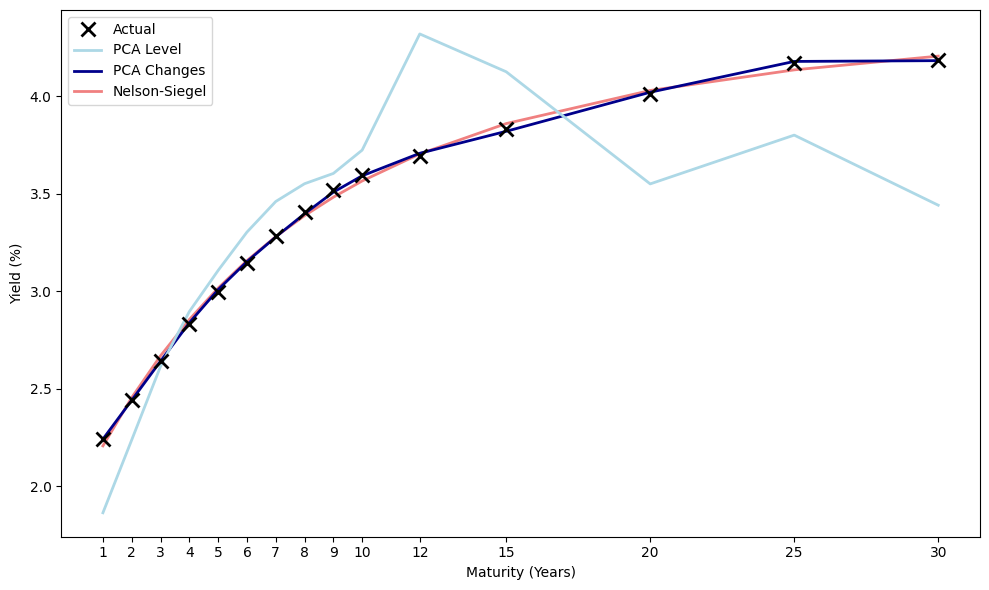


Fit Summary for 2005-01-27:
  PCA Level RMSE: 0.3349 bp
  PCA Changes RMSE: 0.0082 bp
  NS RMSE: 0.0239 bp

Ratio Analysis:
  PCA Level/NS: 14.0288 (PCA Level 1302.9% worse)
  PCA Level/Changes: 40.9802 (PCA Level 3998.0% worse)
  PCA Changes/NS: 0.3423 (PCA Changes 65.8% better)

Stability Ratios (Stale/Fresh):
  PCA Level: 1.0821
  PCA Changes: 0.6794
  NS: 1.0039


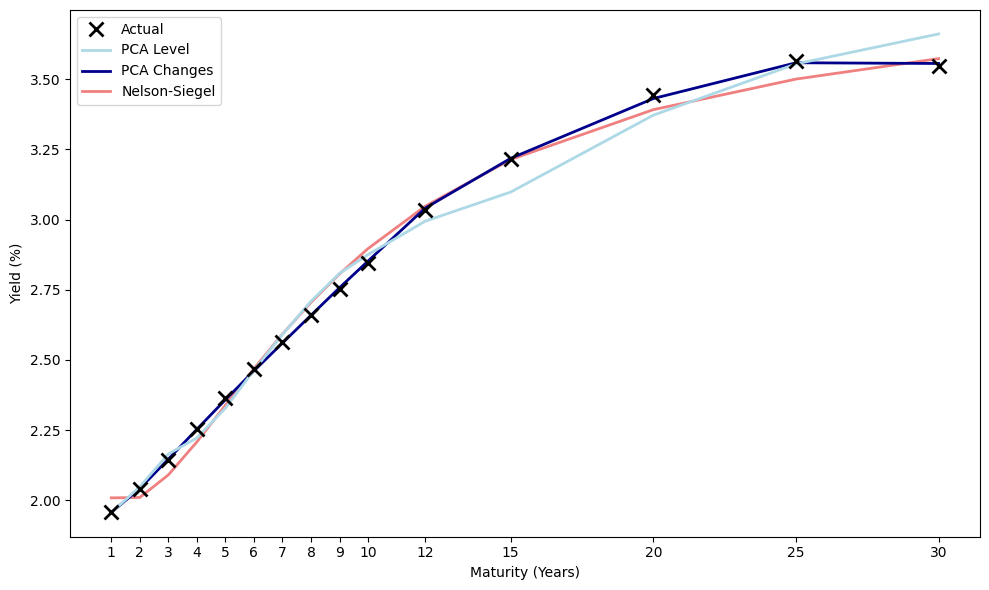


Fit Summary for 2026-01-28:
  PCA Level RMSE: 0.0540 bp
  PCA Changes RMSE: 0.0054 bp
  NS RMSE: 0.0404 bp

Ratio Analysis:
  PCA Level/NS: 1.3373 (PCA Level 33.7% worse)
  PCA Level/Changes: 10.0033 (PCA Level 900.3% worse)
  PCA Changes/NS: 0.1337 (PCA Changes 86.6% better)

Stability Ratios (Stale/Fresh):
  PCA Level: nan
  PCA Changes: nan
  NS: nan


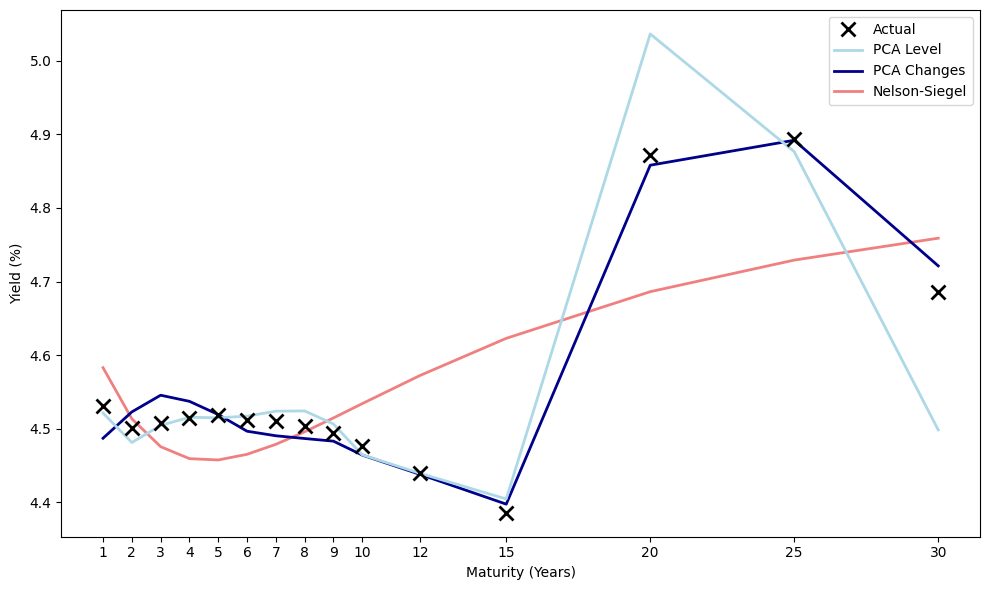


Fit Summary for 2008-06-24:
  PCA Level RMSE: 0.0654 bp
  PCA Changes RMSE: 0.0217 bp
  NS RMSE: 0.1026 bp

Ratio Analysis:
  PCA Level/NS: 0.6371 (PCA Level 36.3% better)
  PCA Level/Changes: 3.0199 (PCA Level 202.0% worse)
  PCA Changes/NS: 0.2110 (PCA Changes 78.9% better)

Stability Ratios (Stale/Fresh):
  PCA Level: 0.9897
  PCA Changes: 1.0732
  NS: 1.0133


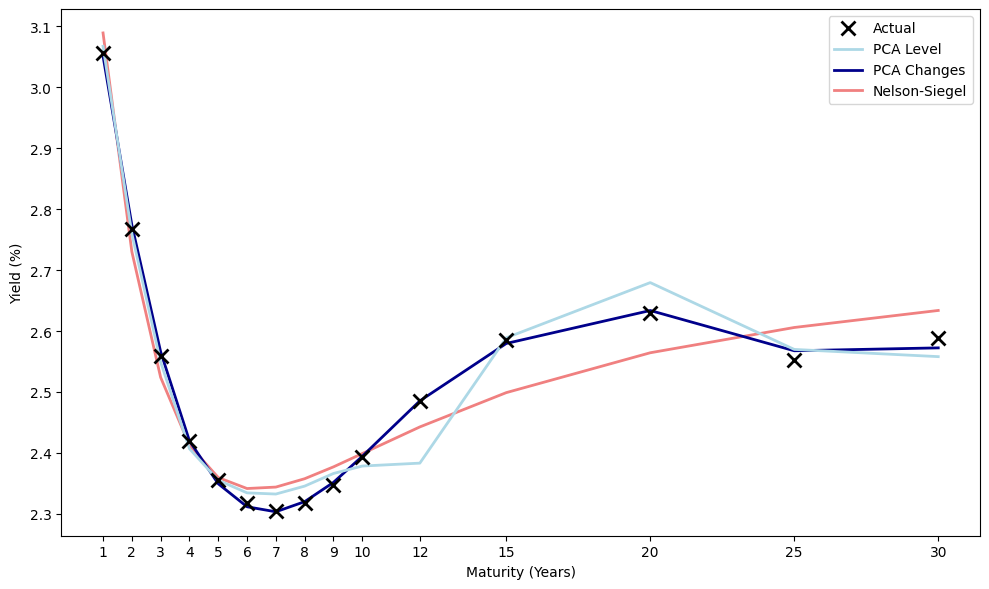


Fit Summary for 2024-06-24:
  PCA Level RMSE: 0.0337 bp
  PCA Changes RMSE: 0.0072 bp
  NS RMSE: 0.0421 bp

Ratio Analysis:
  PCA Level/NS: 0.8008 (PCA Level 19.9% better)
  PCA Level/Changes: 4.7182 (PCA Level 371.8% worse)
  PCA Changes/NS: 0.1697 (PCA Changes 83.0% better)

Stability Ratios (Stale/Fresh):
  PCA Level: 0.9862
  PCA Changes: 1.0023
  NS: 0.9984


In [9]:

plot_yield_curve_fit('2005-01-27') # Best PCA/NS ratio
plot_yield_curve_fit('2026-01-28') # Worst PCA/NS ratio
plot_yield_curve_fit('2008-06-24') # Worst PCA fit
plot_yield_curve_fit('2024-06-24') # Worst NS fit

# PCA changes with lags

In [22]:
# ============================================
# COMPLETE YIELD CURVE CHANGES AND PCA ANALYSIS
# ENHANCED: Now includes lagged factors in same coordinate system
# ============================================

import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA

# ============================================
# 2. CREATE YIELD CURVE CHANGES DATASET
# ============================================

print("\n" + "="*80)
print("CREATING YIELD CURVE CHANGES DATASET")
print("="*80)

# Define zero yield columns
zero_columns = ['ZERO_1Y', 'ZERO_2Y', 'ZERO_3Y', 'ZERO_4Y', 'ZERO_5Y', 
                'ZERO_6Y', 'ZERO_7Y', 'ZERO_8Y', 'ZERO_9Y', 'ZERO_10Y',
                'ZERO_12Y', 'ZERO_15Y', 'ZERO_20Y', 'ZERO_25Y', 'ZERO_30Y']

# CRITICAL: Start with a COPY of df to avoid any issues
df_changes = df.copy()

# Calculate changes IN PLACE on the copied dataframe
for col in zero_columns:
    df_changes[col] = df_changes[col].diff()
# Calculate change for IV
df_changes['IV'] = df_changes['IV'].diff()

# Check for any unexpected NaN values before dropping first row
print(f"\nBefore dropping first row:")
print(f"  Total rows: {len(df_changes)}")
print(f"  NaN count per column:")
for col in zero_columns + ['IV']:
    nan_count = df_changes[col].isna().sum()
    if nan_count > 1:  # Should only be 1 NaN (first row)
        print(f"    ⚠ WARNING: {col} has {nan_count} NaN values (expected 1)")

# Drop ONLY the first row (which has NaN from diff)
df_changes = df_changes.iloc[1:].reset_index(drop=True)

print(f"\n✓ Changes calculated successfully!")
print(f"  Original df rows: {len(df)}")
print(f"  df_changes rows: {len(df_changes)} (1 row dropped)")
print(f"  Expected: {len(df) - 1}")

# Verify no rows lost unexpectedly
if len(df_changes) != len(df) - 1:
    print(f"  ⚠ WARNING: Expected {len(df) - 1} rows but got {len(df_changes)}")
    print(f"  Missing {len(df) - 1 - len(df_changes)} rows!")
else:
    print(f"  ✓ Correct number of rows!")

print(f"  Date range: {df_changes['REFERENCE_DATE'].min().date()} to {df_changes['REFERENCE_DATE'].max().date()}")
# Check for any remaining NaN values
nan_check = df_changes[zero_columns + ['IV']].isna().sum()
if nan_check.sum() > 0:
    print(f"\n⚠ WARNING: NaN values found after dropping first row:")
    print(nan_check[nan_check > 0])

# Display summary statistics
print(f"\nChange Statistics (first 3 maturities):")
for col in zero_columns[:3]:
    print(f"  {col}: mean={df_changes[col].mean():.6f}, std={df_changes[col].std():.6f}")
print(f"  IV: mean={df_changes['IV'].mean():.6f}, std={df_changes['IV'].std():.6f}")

# Save to CSV
save_path = filepath
filename_changes = "DE_YieldCurve_Changes.csv"
full_path_changes = os.path.join(save_path, filename_changes)

df_changes.to_csv(full_path_changes, index=False)

print(f"\n✓ Saved: {filename_changes}")
print(f"  Location: {save_path}")
print(f"  Rows: {len(df_changes)}")
print(f"  Columns: {len(df_changes.columns)}")

# ============================================
# 4. CREATE PCA TRAINING MATRIX WITH LAGGED FACTORS
# ============================================
print("\n" + "="*80)
print("CREATING PCA TRAINING MATRIX WITH LAGGED FACTORS")
print("="*80)
print("\n✨ NEW FEATURE: All lagged factors projected onto same coordinate system (L_t)")

# ============================================
# PARAMETERS
# ============================================

lookback = 756  # 3 years * 252 trading days
future = 21     # ~1 month in trading days
lags = 60       # Number of lagged observations to include
n_factors = 4   # Number of principal components

print(f"\nParameters:")
print(f"  Lookback window: {lookback} trading days ({lookback/252:.2f} years)")
print(f"  Forecast horizon: {future} trading days (~1 month)")
print(f"  Number of lags: {lags} trading days")
print(f"  Number of factors: {n_factors}")
print(f"\n  📊 This creates {lags * 7} additional lagged columns")
print(f"     ({lags} lags × [{n_factors} factors + 3 errors])")

# ============================================
# INITIALIZE STORAGE
# ============================================

# Column names for loadings (15 maturities × n_factors PCs)
maturity_names = ['1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', 
                  '12Y', '15Y', '20Y', '25Y', '30Y']
loading_columns = []
for mat in maturity_names:
    for pc in range(1, n_factors + 1):
        loading_columns.append(f'L_{mat}_PC{pc}')

# Factor column names
current_factor_cols = [f'CURRENT_PC{i}' for i in range(1, n_factors + 1)]
current_error_cols = ['RMSE_CURRENT', 'MAE_CURRENT', 'TAE_CURRENT']

# Lagged factor column names
lagged_columns = []
for lag in range(1, lags + 1):
    for i in range(1, n_factors + 1):
        lagged_columns.append(f'LAG{lag}_PC{i}')
    lagged_columns.extend([f'RMSE_LAG{lag}', f'MAE_LAG{lag}', f'TAE_LAG{lag}'])

future_factor_cols = [f'FUTURE_PC{i}' for i in range(1, n_factors + 1)]
future_error_cols = ['RMSE_FUTURE', 'MAE_FUTURE', 'TAE_FUTURE']

# Eigenvalue column names
eigenval_cols = [f'EIGENVAL_{i}' for i in range(1, n_factors + 1)]

# All column names
columns = (
    ['CURRENT_DATE', 'FORECASTED_DATE'] +
    eigenval_cols +
    loading_columns +
    current_factor_cols + current_error_cols +
    lagged_columns +
    future_factor_cols + future_error_cols
)

# Initialize list to store rows
data_rows = []

print(f"\nTotal columns in df_pca_changes: {len(columns)}")
print(f"  - 2 date columns")
print(f"  - {n_factors} eigenvalue columns")
print(f"  - {len(loading_columns)} loading columns (15 maturities × {n_factors} PCs)")
print(f"  - {n_factors + 3} current state columns ({n_factors} factors + 3 errors)")
print(f"  - {len(lagged_columns)} lagged state columns ({lags} lags × 7)")
print(f"  - {n_factors + 3} future state columns ({n_factors} factors + 3 errors)")

# ============================================
# GENERATE TRAINING MATRIX
# ============================================
print(f"\n{'='*80}")
print("GENERATING OBSERVATIONS...")
print("="*80)

# Starting index: need lookback history + lags + future for earliest lag
start_idx = lookback + lags + future

# Ending index: need future data available
end_idx = len(df_changes) - future

n_observations = end_idx - start_idx

print(f"\nProcessing {n_observations} observations...")
print(f"  Start index: {start_idx} (date: {df_changes.iloc[start_idx]['REFERENCE_DATE'].date()})")
print(f"  End index: {end_idx} (date: {df_changes.iloc[end_idx]['REFERENCE_DATE'].date()})")
print(f"  Last forecast date: {df_changes.iloc[end_idx + future - 1]['REFERENCE_DATE'].date()}")

# Progress tracking
progress_interval = max(1, n_observations // 10)

for i in range(start_idx, end_idx):
    # Progress indicator
    if (i - start_idx) % progress_interval == 0:
        progress = ((i - start_idx) / n_observations) * 100
        print(f"  Progress: {progress:.0f}% (observation {i-start_idx+1}/{n_observations})")
    
    # ============================================
    # 1. DEFINE DATES
    # ============================================
    
    current_idx = i
    future_idx = i + future
    
    current_date = df_changes.iloc[current_idx]['REFERENCE_DATE']
    forecasted_date = df_changes.iloc[future_idx]['REFERENCE_DATE']
    
    # ============================================
    # 2. ESTIMATE PCA ON LOOKBACK WINDOW (DAILY CHANGES)
    # ============================================
    
    # Window: [current_idx - lookback : current_idx]
    window_start = current_idx - lookback
    window_end = current_idx
    
    Y_window = df_changes.iloc[window_start:window_end][zero_columns].values
    
    # Fit PCA on daily changes
    pca = PCA(n_components=n_factors)
    pca.fit(Y_window)
    
    # Get eigenvalues
    eigenvalues = pca.explained_variance_
    
    # Get loadings (15 × n_factors matrix)
    loadings = pca.components_.T  # Transpose to get (15 × n_factors)
    
    # Flatten loadings for storage (row-major order)
    loadings_flat = loadings.flatten()  # 15 * n_factors values
    
    # ============================================
    # 3. CURRENT STATE (21-day CUMULATIVE change ending at t)
    # ============================================
    
    # Get levels from original df (adjust index: df_changes index i → df index i+1)
    past_idx_in_df = (current_idx - future) + 1  # t-21 in df coordinates
    current_idx_in_df = current_idx + 1          # t in df coordinates
    
    y_past_level = df.iloc[past_idx_in_df][zero_columns].values
    y_current_level = df.iloc[current_idx_in_df][zero_columns].values
    
    # Cumulative change from t-21 to t
    cumulative_change_current = y_current_level - y_past_level
    y_current = cumulative_change_current.reshape(1, -1)  # (1 × 15)
    
    # Calculate current factors: f = y @ L
    factors_current = y_current @ loadings  # (1 × n_factors)
    factors_current = factors_current.flatten()
    
    # Reconstruct current cumulative change
    y_current_reconstructed = factors_current @ loadings.T  # (1 × 15)
    
    # Calculate errors
    errors_current = y_current.flatten() - y_current_reconstructed
    rmse_current = np.sqrt(np.mean(errors_current**2))
    mae_current = np.mean(np.abs(errors_current))
    tae_current = np.sum(np.abs(errors_current))
    
    # ============================================
    # 4. LAGGED STATES (projected onto L_t)
    # ============================================
    
    lagged_factors_and_errors = []
    
    for lag_k in range(1, lags + 1):
        # For lag k: cumulative change from (t-k-future) to (t-k)
        lag_past_idx = current_idx - lag_k - future
        lag_current_idx = current_idx - lag_k
        
        # Get levels from original df
        lag_past_idx_in_df = lag_past_idx + 1
        lag_current_idx_in_df = lag_current_idx + 1
        
        y_lag_past_level = df.iloc[lag_past_idx_in_df][zero_columns].values
        y_lag_current_level = df.iloc[lag_current_idx_in_df][zero_columns].values
        
        # Cumulative change for this lag
        cumulative_change_lag = y_lag_current_level - y_lag_past_level
        y_lag = cumulative_change_lag.reshape(1, -1)  # (1 × 15)
        
        # Project onto CURRENT loadings L_t
        factors_lag = y_lag @ loadings  # (1 × n_factors)
        factors_lag = factors_lag.flatten()
        
        # Reconstruct using CURRENT loadings
        y_lag_reconstructed = factors_lag @ loadings.T  # (1 × 15)
        
        # Calculate errors
        errors_lag = y_lag.flatten() - y_lag_reconstructed
        rmse_lag = np.sqrt(np.mean(errors_lag**2))
        mae_lag = np.mean(np.abs(errors_lag))
        tae_lag = np.sum(np.abs(errors_lag))
        
        # Store factors and errors for this lag
        lagged_factors_and_errors.extend(factors_lag)
        lagged_factors_and_errors.extend([rmse_lag, mae_lag, tae_lag])
    
    # ============================================
    # 5. FUTURE STATE (21-day CUMULATIVE change from t to t+21)
    # ============================================
    
    # Get levels from original df
    future_idx_in_df = future_idx + 1  # t+21 in df coordinates
    
    y_future_level = df.iloc[future_idx_in_df][zero_columns].values
    
    # Cumulative change from t to t+21
    cumulative_change_future = y_future_level - y_current_level
    y_future = cumulative_change_future.reshape(1, -1)  # (1 × 15)
    
    # Calculate future factors using CURRENT loadings: f = y @ L_current
    factors_future = y_future @ loadings  # (1 × n_factors)
    factors_future = factors_future.flatten()
    
    # Reconstruct future cumulative change using CURRENT loadings
    y_future_reconstructed = factors_future @ loadings.T  # (1 × 15)
    
    # Calculate errors
    errors_future = y_future.flatten() - y_future_reconstructed
    rmse_future = np.sqrt(np.mean(errors_future**2))
    mae_future = np.mean(np.abs(errors_future))
    tae_future = np.sum(np.abs(errors_future))
    
    # ============================================
    # 6. STORE ROW
    # ============================================
    
    row = [
        current_date,
        forecasted_date,
        *eigenvalues,  # 4 eigenvalue values
        *loadings_flat,  # 15 * n_factors loading values
        *factors_current,  # n_factors current factor values
        rmse_current, mae_current, tae_current,
        *lagged_factors_and_errors,  # lags * 7 values
        *factors_future,  # n_factors future factor values
        rmse_future, mae_future, tae_future
    ]
    
    data_rows.append(row)

# ============================================
# CREATE DATAFRAME
# ============================================

print(f"\n{'='*80}")
print("CREATING DATAFRAME...")
print("="*80)

df_pca_changes = pd.DataFrame(data_rows, columns=columns)

print(f"\n✓ df_pca_changes created successfully!")
print(f"  Shape: {df_pca_changes.shape}")
print(f"  Columns: {len(df_pca_changes.columns)}")
print(f"  Rows: {len(df_pca_changes)}")

# ============================================
# CALCULATE PROPER RATIOS (FRESH vs STALE)
# ============================================

print(f"\n{'='*80}")
print("CALCULATING LOADING STABILITY RATIOS")
print("="*80)
print("\nComparing fresh loadings (L_t+h) vs stale loadings (L_t) for same cumulative change at t+h")

# Initialize ratio columns with NaN
df_pca_changes['RMSE_RATIO'] = np.nan
df_pca_changes['MAE_RATIO'] = np.nan
df_pca_changes['TAE_RATIO'] = np.nan

# For each row, find the corresponding "fresh" loadings row
ratio_count = 0
for idx in range(len(df_pca_changes)):
    forecasted_date = df_pca_changes.iloc[idx]['FORECASTED_DATE']
    
    # Find row where CURRENT_DATE equals this FORECASTED_DATE
    fresh_row = df_pca_changes[df_pca_changes['CURRENT_DATE'] == forecasted_date]
    
    if len(fresh_row) > 0:
        fresh_row = fresh_row.iloc[0]
        
        # Calculate ratios: stale (FUTURE from current row) / fresh (CURRENT from matched row)
        rmse_ratio = df_pca_changes.iloc[idx]['RMSE_FUTURE'] / fresh_row['RMSE_CURRENT']
        mae_ratio = df_pca_changes.iloc[idx]['MAE_FUTURE'] / fresh_row['MAE_CURRENT']
        tae_ratio = df_pca_changes.iloc[idx]['TAE_FUTURE'] / fresh_row['TAE_CURRENT']
        
        # Store ratios
        df_pca_changes.at[idx, 'RMSE_RATIO'] = rmse_ratio
        df_pca_changes.at[idx, 'MAE_RATIO'] = mae_ratio
        df_pca_changes.at[idx, 'TAE_RATIO'] = tae_ratio
        
        ratio_count += 1

print(f"\n✓ Calculated ratios for {ratio_count} observations")
print(f"  Missing ratios (first {future} observations): {len(df_pca_changes) - ratio_count}")

# ============================================
# SUMMARY STATISTICS
# ============================================

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print("="*80)

print(f"\nDate Range:")
print(f"  First current date: {df_pca_changes['CURRENT_DATE'].min().date()}")
print(f"  Last current date: {df_pca_changes['CURRENT_DATE'].max().date()}")
print(f"  First forecast date: {df_pca_changes['FORECASTED_DATE'].min().date()}")
print(f"  Last forecast date: {df_pca_changes['FORECASTED_DATE'].max().date()}")

print(f"\nEigenvalue Statistics:")
eigenval_stats = df_pca_changes[eigenval_cols].describe()
print(eigenval_stats)

print(f"\nFactor Statistics (Current - 21-day cumulative):")
factor_stats_current = df_pca_changes[current_factor_cols].describe()
print(factor_stats_current.round(6))

print(f"\nFactor Statistics (Future - 21-day cumulative):")
factor_stats_future = df_pca_changes[future_factor_cols].describe()
print(factor_stats_future.round(6))

# Sample of lagged factor statistics
print(f"\nSample Lagged Factor Statistics (LAG1 and LAG{lags}):")
lag1_cols = [f'LAG1_PC{i}' for i in range(1, n_factors + 1)]
lag_last_cols = [f'LAG{lags}_PC{i}' for i in range(1, n_factors + 1)]
sample_lag_stats = df_pca_changes[lag1_cols + lag_last_cols].describe()
print(sample_lag_stats.round(6))

print(f"\nError Statistics (Current - Fresh Loadings):")
error_stats_current = df_pca_changes[current_error_cols].describe()
print(error_stats_current)

print(f"\nError Statistics (Future - Stale Loadings):")
error_stats_future = df_pca_changes[future_error_cols].describe()
print(error_stats_future)

print(f"\n{'='*80}")
print("TESTING L_t ≈ L_t+h ASSUMPTION (CUMULATIVE CHANGES)")
print("="*80)
print("\nComparing same 21-day cumulative change reconstructed with fresh vs stale loadings")

# Summary statistics for ratios (excluding NaN)
ratio_stats = df_pca_changes[['RMSE_RATIO', 'MAE_RATIO', 'TAE_RATIO']].describe()
print(f"\nRatio Statistics (Stale/Fresh):")
print(ratio_stats)

# Detailed interpretation for each metric
for metric in ['RMSE', 'MAE', 'TAE']:
    ratio_col = f'{metric}_RATIO'
    mean_ratio = df_pca_changes[ratio_col].mean()
    median_ratio = df_pca_changes[ratio_col].median()
    
    print(f"\n{metric} Ratio Analysis:")
    print(f"  Mean: {mean_ratio:.4f} (stale loadings increase {metric} by {(mean_ratio-1)*100:.1f}%)")
    print(f"  Median: {median_ratio:.4f} (stale loadings increase {metric} by {(median_ratio-1)*100:.1f}%)")
    
    if mean_ratio < 1.1:
        print(f"  ✓✓✓ EXCELLENT: Loading stability assumption is VALID")
    elif mean_ratio < 1.5:
        print(f"  ✓ ACCEPTABLE: Loading stability assumption is reasonable")
    else:
        print(f"  ✗ CONCERNING: Loading stability assumption may be questionable")

# ============================================
# SAVE TO CSV
# ============================================

print(f"\n{'='*80}")
print("SAVING df_pca_changes TO CSV")
print("="*80)

filename_pca = "PCA_fit_changes_with_lags.csv"
full_path_pca = os.path.join(save_path, filename_pca)

df_pca_changes.to_csv(full_path_pca, index=False)

print(f"\n✓ Saved: {filename_pca}")
print(f"  Location: {save_path}")
print(f"  Rows: {len(df_pca_changes)}")
print(f"  Columns: {len(df_pca_changes.columns)}")

print(f"\n{'='*80}")
print("df_pca_changes WITH LAGGED FACTORS READY FOR ANN TRAINING")
print("="*80)

# Display first few rows (selected columns)
print(f"\nFirst 3 rows (selected columns):")
display_cols = (['CURRENT_DATE', 'FORECASTED_DATE'] + 
                eigenval_cols[:2] +  # First 2 eigenvalues
                current_factor_cols + current_error_cols +
                [f'LAG1_PC{i}' for i in range(1, n_factors + 1)] + ['RMSE_LAG1'] +  # LAG1 sample
                future_factor_cols + future_error_cols +
                ['RMSE_RATIO', 'MAE_RATIO', 'TAE_RATIO'])
print(df_pca_changes[display_cols].head(3))

print(f"\n{'='*80}")
print("✓ COMPLETE - Enhanced PCA matrix with lagged factors generation complete!")
print(f"✨ All {lags} lagged observations projected onto same coordinate system")
print("="*80)


CREATING YIELD CURVE CHANGES DATASET

Before dropping first row:
  Total rows: 6960
  NaN count per column:

✓ Changes calculated successfully!
  Original df rows: 6960
  df_changes rows: 6959 (1 row dropped)
  Expected: 6959
  ✓ Correct number of rows!
  Date range: 1999-01-05 to 2026-01-28

Change Statistics (first 3 maturities):
  ZERO_1Y: mean=-0.000001, std=0.000347
  ZERO_2Y: mean=-0.000001, std=0.000390
  ZERO_3Y: mean=-0.000001, std=0.000423
  IV: mean=-0.001946, std=1.763601

✓ Saved: DE_YieldCurve_Changes.csv
  Location: \\GIMECB01\HOMEDIR-VZ$\westenb\Thesis\Data
  Rows: 6959
  Columns: 17

CREATING PCA TRAINING MATRIX WITH LAGGED FACTORS

✨ NEW FEATURE: All lagged factors projected onto same coordinate system (L_t)

Parameters:
  Lookback window: 756 trading days (3.00 years)
  Forecast horizon: 21 trading days (~1 month)
  Number of lags: 60 trading days
  Number of factors: 4

  📊 This creates 420 additional lagged columns
     (60 lags × [4 factors + 3 errors])

Total co

# Cross correlation between Current PCs and Future PCs

Dataset shape: (6101, 504)
Date range: 2002-03-22 00:00:00 to 2025-12-30 00:00:00
IV values matched: 6101/6101
Inferred forecast horizon: ~29 calendar days

Calculating Spearman correlations...
✓ All Spearman correlations calculated


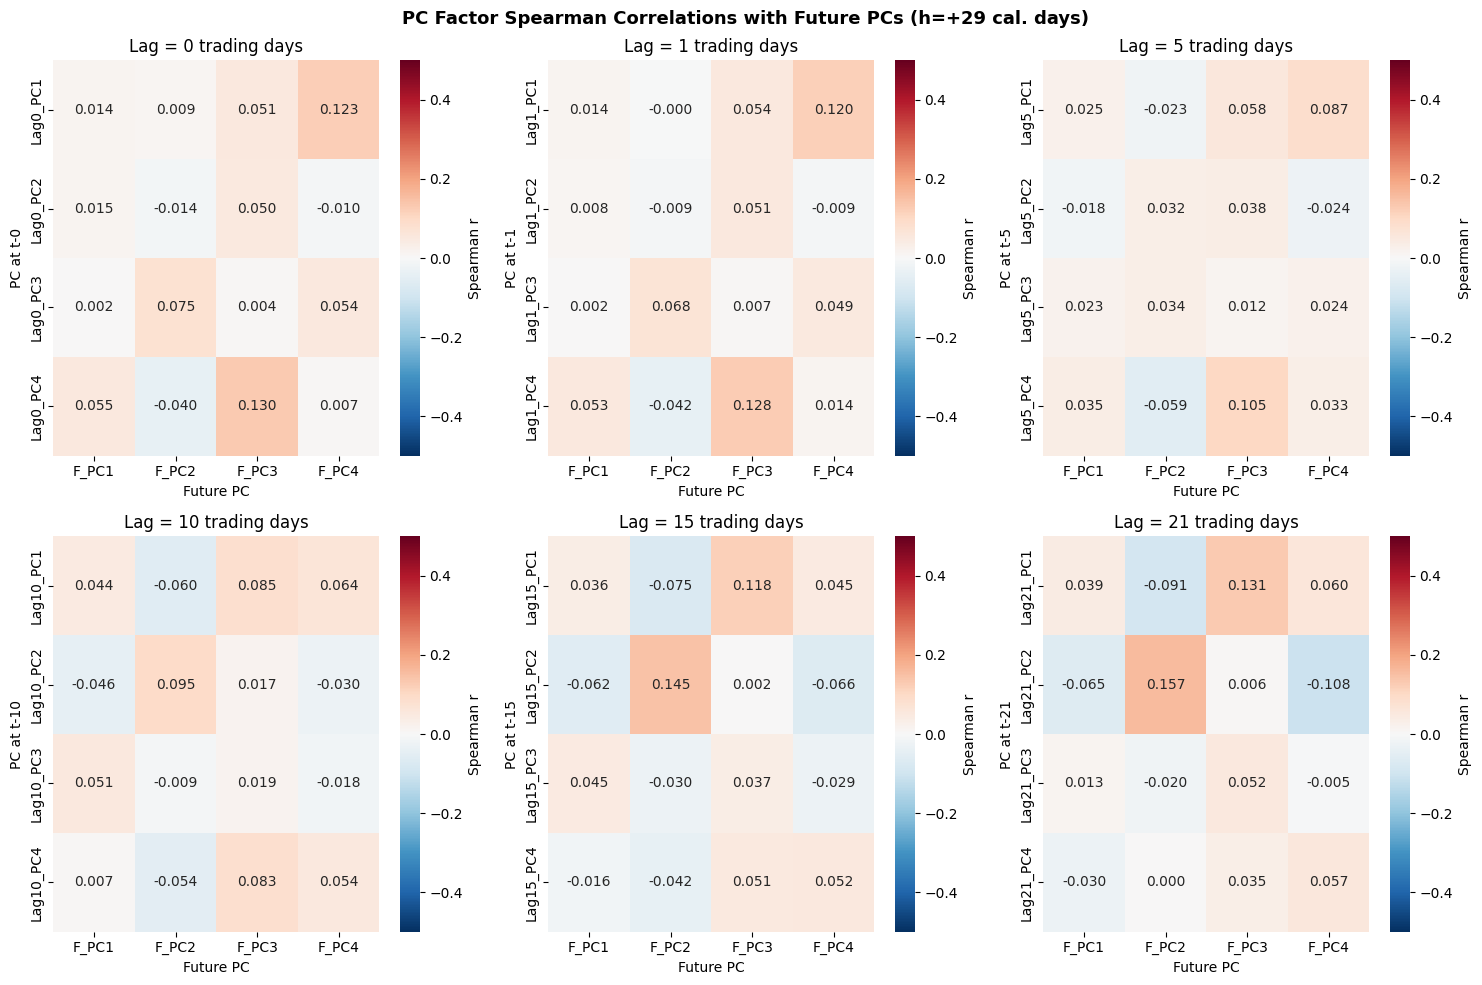

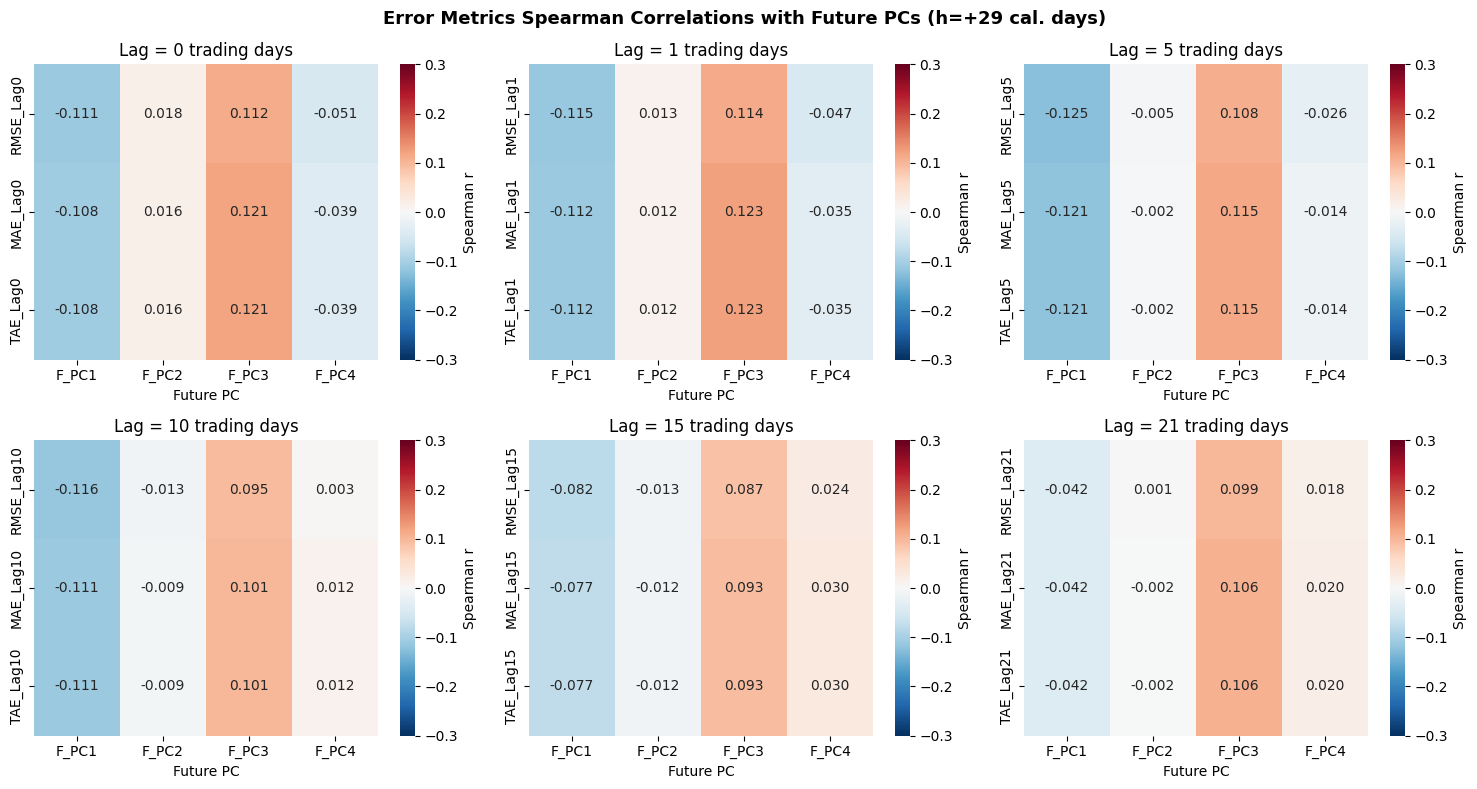

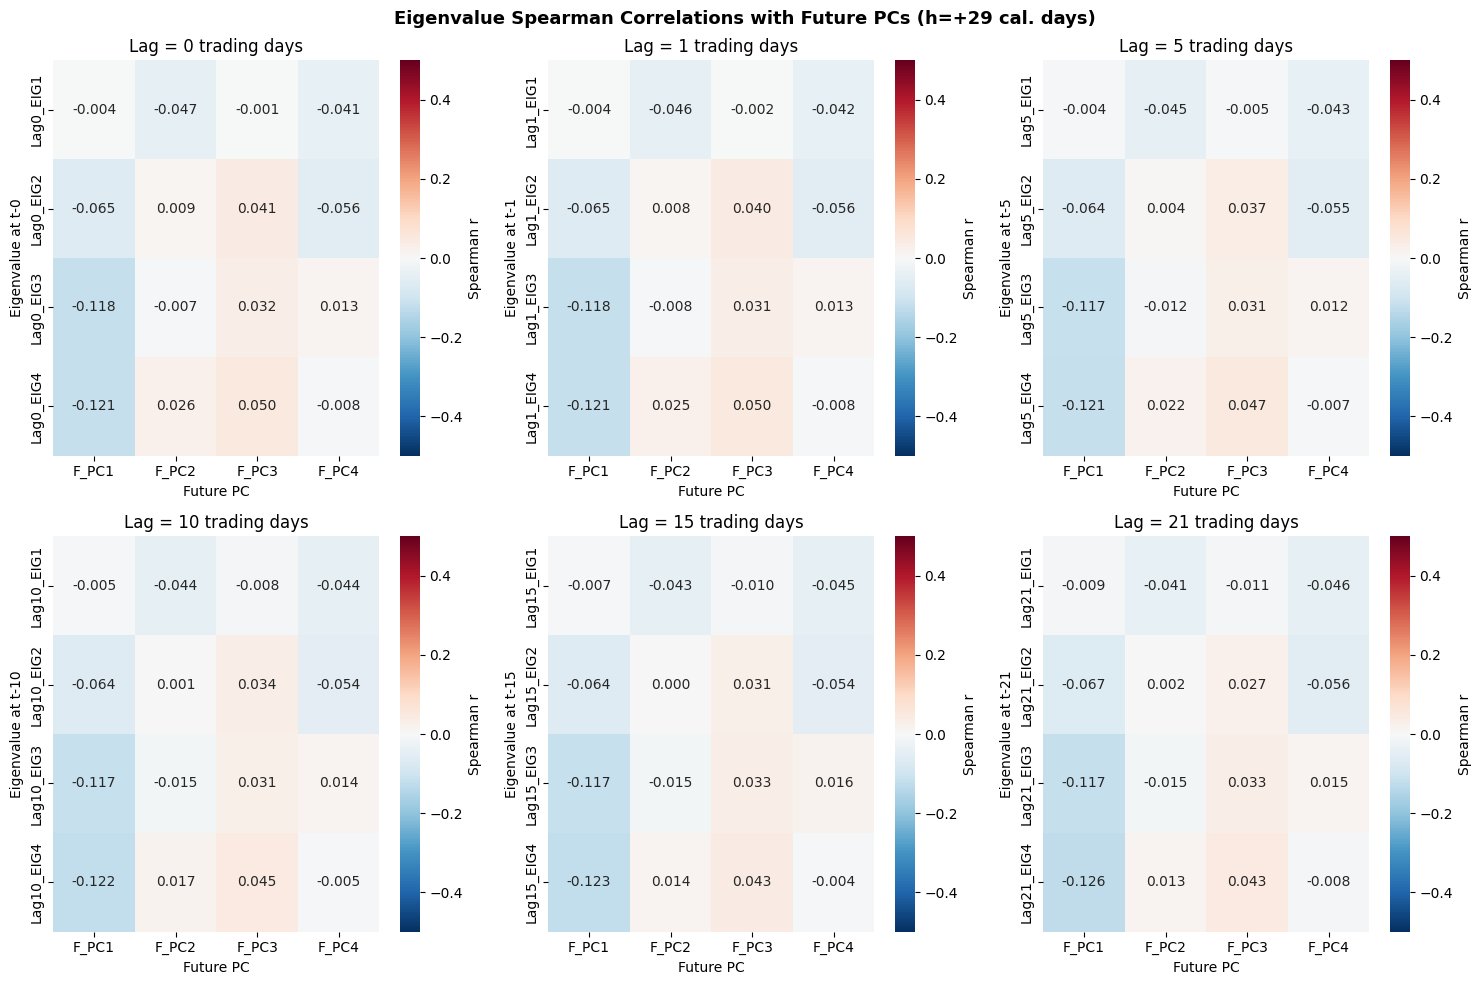

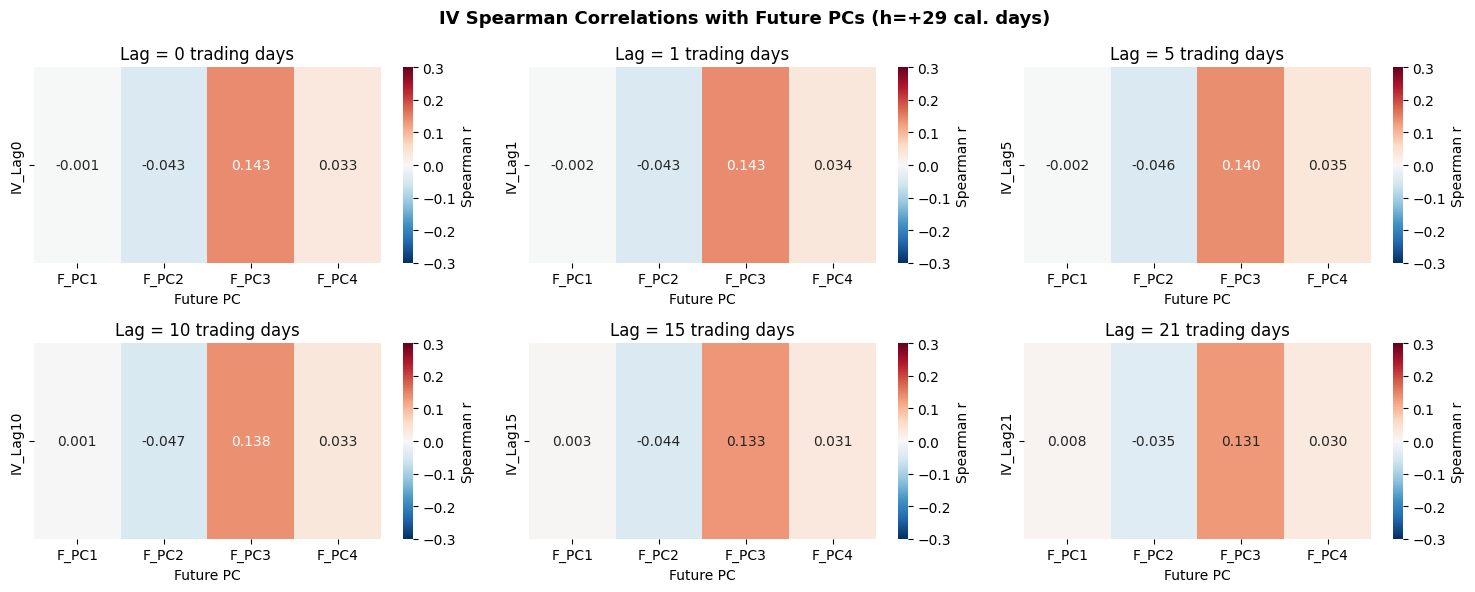

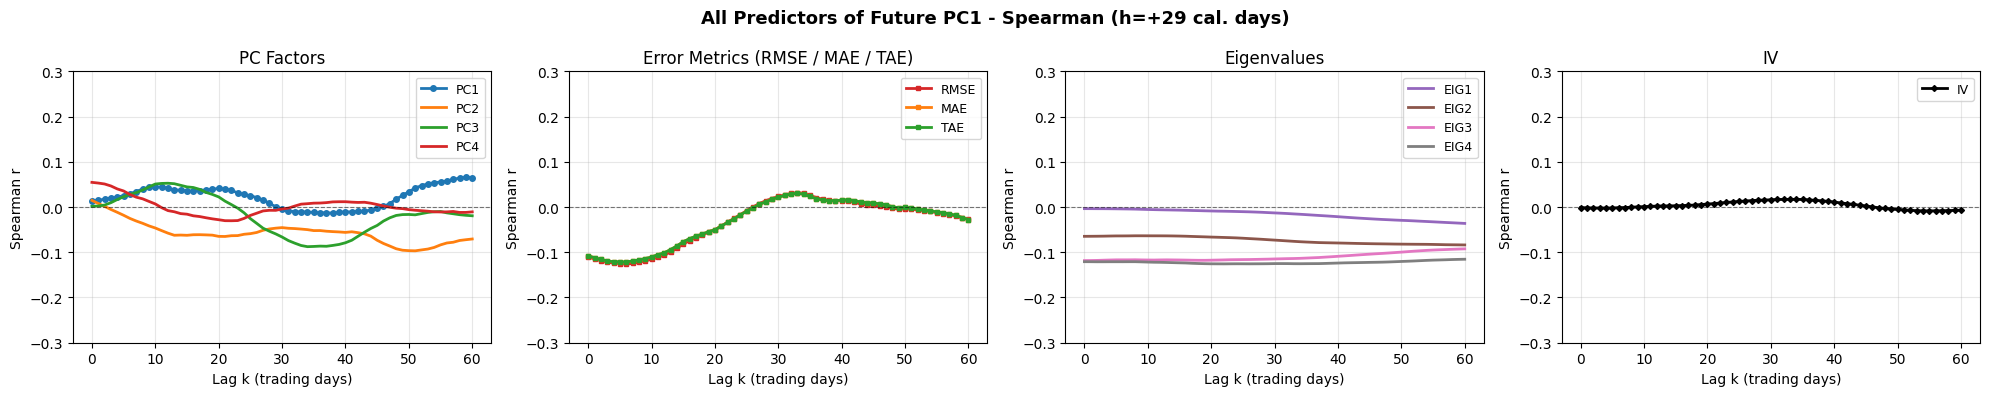

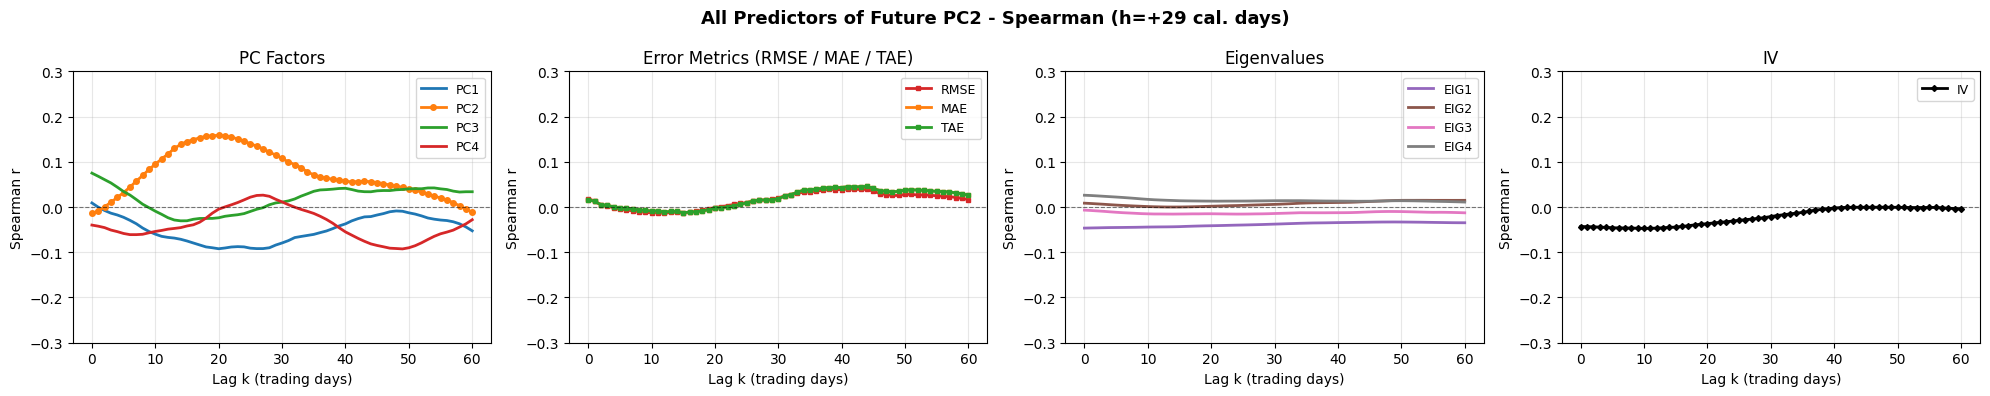

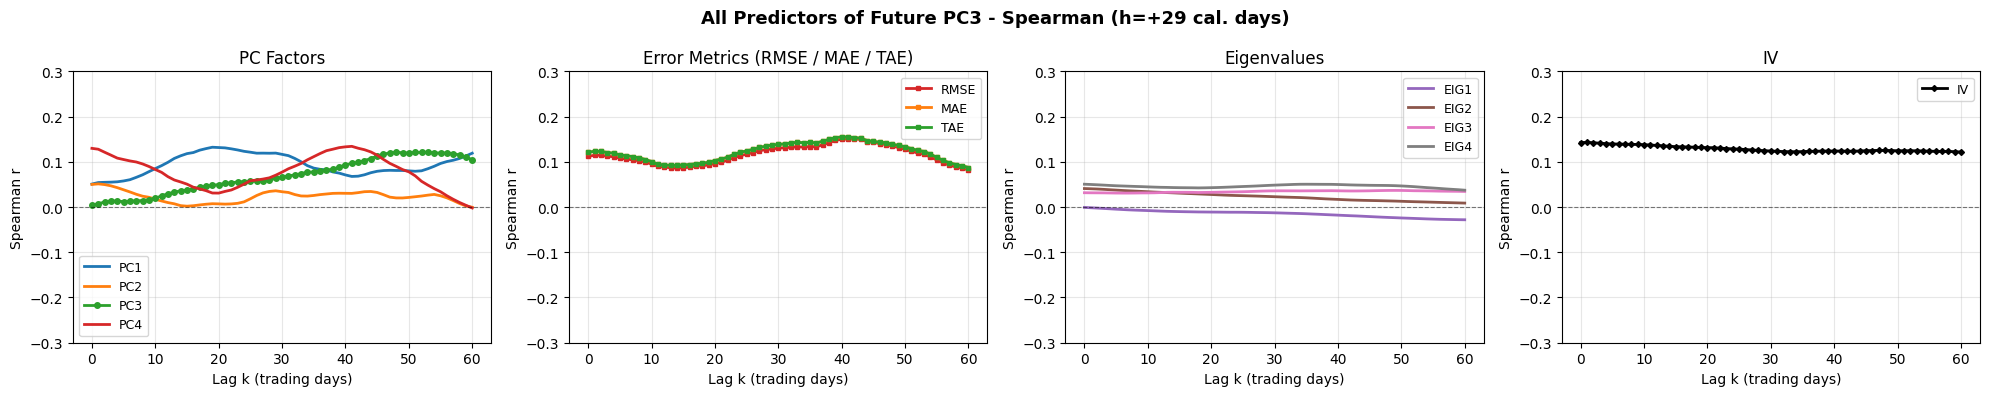

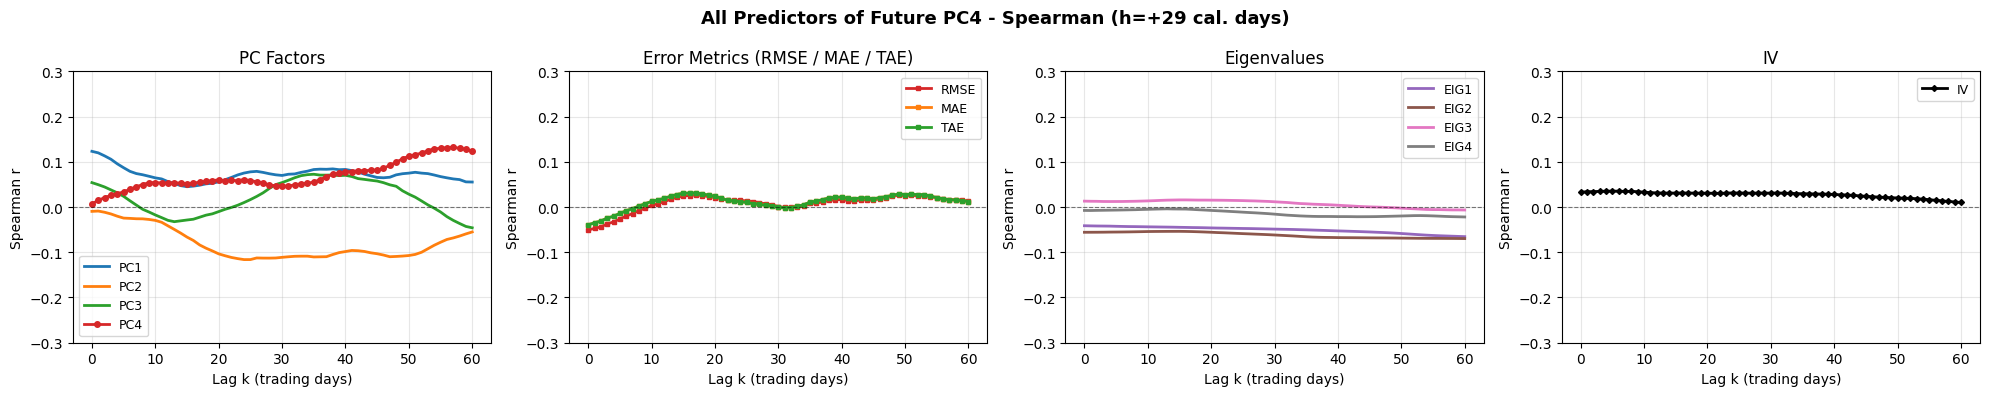


BEST PREDICTORS SUMMARY - SPEARMAN (h=+29 calendar days)

Future PC1:
  Best PC:    PC2          at lag 51 | Spearman r = -0.097
  Best Error: RMSE         at lag  6 | Spearman r = -0.126
  Best EIG:   EIG4         at lag 22 | Spearman r = -0.126
  Best IV:                  at lag 33 | Spearman r = +0.017
  IV at lag 0:                       | Spearman r = -0.001
  Error metrics at lag 0:
    RMSE: -0.111
    MAE: -0.108
    TAE: -0.108

Future PC2:
  Best PC:    PC2          at lag 20 | Spearman r = +0.159
  Best Error: MAE          at lag 44 | Spearman r = +0.046
  Best EIG:   EIG1         at lag  0 | Spearman r = -0.047
  Best IV:                  at lag 10 | Spearman r = -0.047
  IV at lag 0:                       | Spearman r = -0.043
  Error metrics at lag 0:
    RMSE: +0.018
    MAE: +0.016
    TAE: +0.016

Future PC3:
  Best PC:    PC4          at lag 41 | Spearman r = +0.134
  Best Error: MAE          at lag 40 | Spearman r = +0.155
  Best EIG:   EIG4         at lag  0 | Spea

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# ============================================
# LOAD DATA
# ============================================

file_path_pca = r"\\GIMECB01\HOMEDIR-VZ$\westenb\Thesis\Data\PCA_fit_changes_with_lags.csv"
file_path_iv  = r"\\GIMECB01\HOMEDIR-VZ$\westenb\Thesis\Data\DE_YieldCurve_IV.csv"

df = pd.read_csv(file_path_pca)
df_iv_raw = pd.read_csv(file_path_iv)

df['CURRENT_DATE']    = pd.to_datetime(df['CURRENT_DATE'])
df['FORECASTED_DATE'] = pd.to_datetime(df['FORECASTED_DATE'])
df_iv_raw['REFERENCE_DATE'] = pd.to_datetime(df_iv_raw['REFERENCE_DATE'])

df = df.sort_values('CURRENT_DATE').reset_index(drop=True)

df = df.merge(df_iv_raw[['REFERENCE_DATE', 'IV']],
              left_on='CURRENT_DATE',
              right_on='REFERENCE_DATE',
              how='left').drop(columns='REFERENCE_DATE')

n_matched = df['IV'].notna().sum()
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['CURRENT_DATE'].min()} to {df['CURRENT_DATE'].max()}")
print(f"IV values matched: {n_matched}/{len(df)}")
if len(df) - n_matched > 10:
    print(f"⚠ WARNING: {len(df) - n_matched} unmatched dates!")
    print(df[df['IV'].isna()]['CURRENT_DATE'].head(10))

forecast_horizon_label = int(
    (df['FORECASTED_DATE'] - df['CURRENT_DATE']).dt.days.mode()[0]
)
print(f"Inferred forecast horizon: ~{forecast_horizon_label} calendar days")

# ============================================
# PARAMETERS
# ============================================

n_lags      = 60
n_factors   = 4
n_eigenvals = 4
error_types = ['RMSE', 'MAE', 'TAE']
n_errors    = len(error_types)

current_pcs   = [f'CURRENT_PC{i}' for i in range(1, n_factors + 1)]
future_pcs    = [f'FUTURE_PC{i}'  for i in range(1, n_factors + 1)]
eigenval_cols = [f'EIGENVAL_{i}'  for i in range(1, n_eigenvals + 1)]

lagged_pc_groups = [current_pcs]
for lag_k in range(1, n_lags + 1):
    lagged_pc_groups.append([f'LAG{lag_k}_PC{i}' for i in range(1, n_factors + 1)])

error_groups = [['RMSE_CURRENT', 'MAE_CURRENT', 'TAE_CURRENT']]
for lag_k in range(1, n_lags + 1):
    error_groups.append([f'RMSE_LAG{lag_k}', f'MAE_LAG{lag_k}', f'TAE_LAG{lag_k}'])

# ============================================
# CALCULATE SPEARMAN CORRELATIONS
# ============================================

print("\nCalculating Spearman correlations...")

corr_pcs    = np.zeros((n_lags + 1, n_factors,   n_factors))
corr_errors = np.zeros((n_lags + 1, n_errors,    n_factors))
corr_eig    = np.zeros((n_lags + 1, n_eigenvals, n_factors))
corr_iv     = np.zeros((n_lags + 1, 1,           n_factors))

for lag_idx in range(n_lags + 1):
    for j, fut_pc_col in enumerate(future_pcs):

        # PC factors (column-based lags - no row shifting needed)
        for i, lag_pc_col in enumerate(lagged_pc_groups[lag_idx]):
            corr_pcs[lag_idx, i, j], _ = spearmanr(
                df[lag_pc_col].values,
                df[fut_pc_col].values
            )

        # RMSE, MAE, TAE (column-based lags - no row shifting needed)
        for e, err_col in enumerate(error_groups[lag_idx]):
            corr_errors[lag_idx, e, j], _ = spearmanr(
                df[err_col].values,
                df[fut_pc_col].values
            )

        # Eigenvalues (row-based lags)
        if lag_idx == 0:
            for i, eig_col in enumerate(eigenval_cols):
                corr_eig[lag_idx, i, j], _ = spearmanr(
                    df[eig_col].values,
                    df[fut_pc_col].values
                )
        else:
            for i, eig_col in enumerate(eigenval_cols):
                corr_eig[lag_idx, i, j], _ = spearmanr(
                    df[eig_col].iloc[:-lag_idx].values,
                    df[fut_pc_col].iloc[lag_idx:].values
                )

        # IV (row-based lags)
        if lag_idx == 0:
            corr_iv[lag_idx, 0, j], _ = spearmanr(
                df['IV'].values,
                df[fut_pc_col].values
            )
        else:
            corr_iv[lag_idx, 0, j], _ = spearmanr(
                df['IV'].iloc[:-lag_idx].values,
                df[fut_pc_col].iloc[lag_idx:].values
            )

print("✓ All Spearman correlations calculated")

# ============================================
# PLOT HELPERS
# ============================================

key_lags      = [0, 1, 5, 10, 15, 21]
lags_range    = np.arange(n_lags + 1)
colors_pcs    = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
colors_eig    = ['#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
colors_errors = ['#d62728', '#ff7f0e', '#2ca02c']  # RMSE, MAE, TAE

# ============================================
# VISUALIZATION 1: PC HEATMAPS
# ============================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
fig.suptitle(f'PC Factor Spearman Correlations with Future PCs (h=+{forecast_horizon_label} cal. days)',
             fontsize=13, fontweight='bold')

for idx, lag in enumerate(key_lags):
    sns.heatmap(corr_pcs[lag], annot=True, fmt='.3f', cmap='RdBu_r',
                center=0, vmin=-0.5, vmax=0.5,
                xticklabels=[f'F_PC{i+1}' for i in range(n_factors)],
                yticklabels=[f'Lag{lag}_PC{i+1}' for i in range(n_factors)],
                ax=axes[idx], cbar_kws={'label': 'Spearman r'})
    axes[idx].set_title(f'Lag = {lag} trading days')
    axes[idx].set_xlabel('Future PC')
    axes[idx].set_ylabel(f'PC at t-{lag}')

plt.tight_layout()
plt.show()

# ============================================
# VISUALIZATION 2: ERROR METRICS HEATMAPS
# ============================================

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
fig.suptitle(f'Error Metrics Spearman Correlations with Future PCs (h=+{forecast_horizon_label} cal. days)',
             fontsize=13, fontweight='bold')

for idx, lag in enumerate(key_lags):
    sns.heatmap(corr_errors[lag], annot=True, fmt='.3f', cmap='RdBu_r',
                center=0, vmin=-0.3, vmax=0.3,
                xticklabels=[f'F_PC{i+1}' for i in range(n_factors)],
                yticklabels=[f'{e}_Lag{lag}' for e in error_types],
                ax=axes[idx], cbar_kws={'label': 'Spearman r'})
    axes[idx].set_title(f'Lag = {lag} trading days')
    axes[idx].set_xlabel('Future PC')

plt.tight_layout()
plt.show()

# ============================================
# VISUALIZATION 3: EIGENVALUE HEATMAPS
# ============================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
fig.suptitle(f'Eigenvalue Spearman Correlations with Future PCs (h=+{forecast_horizon_label} cal. days)',
             fontsize=13, fontweight='bold')

for idx, lag in enumerate(key_lags):
    sns.heatmap(corr_eig[lag], annot=True, fmt='.3f', cmap='RdBu_r',
                center=0, vmin=-0.5, vmax=0.5,
                xticklabels=[f'F_PC{i+1}' for i in range(n_factors)],
                yticklabels=[f'Lag{lag}_EIG{i+1}' for i in range(n_eigenvals)],
                ax=axes[idx], cbar_kws={'label': 'Spearman r'})
    axes[idx].set_title(f'Lag = {lag} trading days')
    axes[idx].set_xlabel('Future PC')
    axes[idx].set_ylabel(f'Eigenvalue at t-{lag}')

plt.tight_layout()
plt.show()

# ============================================
# VISUALIZATION 4: IV HEATMAPS
# ============================================

fig, axes = plt.subplots(2, 3, figsize=(15, 6))
axes = axes.flatten()
fig.suptitle(f'IV Spearman Correlations with Future PCs (h=+{forecast_horizon_label} cal. days)',
             fontsize=13, fontweight='bold')

for idx, lag in enumerate(key_lags):
    sns.heatmap(corr_iv[lag], annot=True, fmt='.3f', cmap='RdBu_r',
                center=0, vmin=-0.3, vmax=0.3,
                xticklabels=[f'F_PC{i+1}' for i in range(n_factors)],
                yticklabels=[f'IV_Lag{lag}'],
                ax=axes[idx], cbar_kws={'label': 'Spearman r'})
    axes[idx].set_title(f'Lag = {lag} trading days')
    axes[idx].set_xlabel('Future PC')

plt.tight_layout()
plt.show()

# ============================================
# VISUALIZATION 5: COMBINED LINE PLOTS PER FUTURE PC
# ============================================

for j in range(n_factors):
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    fig.suptitle(f'All Predictors of Future PC{j+1} - Spearman (h=+{forecast_horizon_label} cal. days)',
                 fontsize=13, fontweight='bold')

    # PC factors
    ax = axes[0]
    for i in range(n_factors):
        ax.plot(lags_range, corr_pcs[:, i, j], label=f'PC{i+1}',
                color=colors_pcs[i], linewidth=2,
                marker='o' if i == j else None, markersize=4)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.set_title('PC Factors')
    ax.set_xlabel('Lag k (trading days)')
    ax.set_ylabel('Spearman r')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.3, 0.3)

    # Error metrics
    ax = axes[1]
    for e, err_name in enumerate(error_types):
        ax.plot(lags_range, corr_errors[:, e, j], label=err_name,
                color=colors_errors[e], linewidth=2, marker='s', markersize=3)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.set_title('Error Metrics (RMSE / MAE / TAE)')
    ax.set_xlabel('Lag k (trading days)')
    ax.set_ylabel('Spearman r')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.3, 0.3)

    # Eigenvalues
    ax = axes[2]
    for i in range(n_eigenvals):
        ax.plot(lags_range, corr_eig[:, i, j], label=f'EIG{i+1}',
                color=colors_eig[i], linewidth=2)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.set_title('Eigenvalues')
    ax.set_xlabel('Lag k (trading days)')
    ax.set_ylabel('Spearman r')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.3, 0.3)

    # IV
    ax = axes[3]
    ax.plot(lags_range, corr_iv[:, 0, j], label='IV',
            color='black', linewidth=2, marker='D', markersize=3)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.set_title('IV')
    ax.set_xlabel('Lag k (trading days)')
    ax.set_ylabel('Spearman r')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.3, 0.3)

    plt.tight_layout()
    plt.show()

# ============================================
# SUMMARY
# ============================================

print("\n" + "="*80)
print(f"BEST PREDICTORS SUMMARY - SPEARMAN (h=+{forecast_horizon_label} calendar days)")
print("="*80)

for j in range(n_factors):
    print(f"\nFuture PC{j+1}:")

    pc_max  = np.unravel_index(np.argmax(np.abs(corr_pcs[:, :, j])),    corr_pcs[:, :, j].shape)
    eig_max = np.unravel_index(np.argmax(np.abs(corr_eig[:, :, j])),    corr_eig[:, :, j].shape)
    err_max = np.unravel_index(np.argmax(np.abs(corr_errors[:, :, j])), corr_errors[:, :, j].shape)
    iv_max  = np.argmax(np.abs(corr_iv[:, 0, j]))

    print(f"  Best PC:    PC{pc_max[1]+1}          at lag {pc_max[0]:2d} | Spearman r = {corr_pcs[pc_max[0], pc_max[1], j]:+.3f}")
    print(f"  Best Error: {error_types[err_max[1]]:4s}         at lag {err_max[0]:2d} | Spearman r = {corr_errors[err_max[0], err_max[1], j]:+.3f}")
    print(f"  Best EIG:   EIG{eig_max[1]+1}         at lag {eig_max[0]:2d} | Spearman r = {corr_eig[eig_max[0], eig_max[1], j]:+.3f}")
    print(f"  Best IV:                  at lag {iv_max:2d} | Spearman r = {corr_iv[iv_max, 0, j]:+.3f}")
    print(f"  IV at lag 0:                       | Spearman r = {corr_iv[0, 0, j]:+.3f}")
    print(f"  Error metrics at lag 0:")
    for e, err_name in enumerate(error_types):
        print(f"    {err_name}: {corr_errors[0, e, j]:+.3f}")

# t-SNE 

# Forecasting using LSTM

## PCA Changes

#### Forecast ready dataset

In [25]:
import pandas as pd
import numpy as np

# ============================================
# LOAD & MERGE
# ============================================

file_path_pca = r"\\GIMECB01\HOMEDIR-VZ$\westenb\Thesis\Data\PCA_fit_changes_with_lags.csv"
file_path_iv  = r"\\GIMECB01\HOMEDIR-VZ$\westenb\Thesis\Data\DE_YieldCurve_IV.csv"
file_path_out = r"\\GIMECB01\HOMEDIR-VZ$\westenb\Thesis\Data\Forecast_Ready.csv"

df = pd.read_csv(file_path_pca)
df_iv_raw = pd.read_csv(file_path_iv)

df['CURRENT_DATE']    = pd.to_datetime(df['CURRENT_DATE'])
df['FORECASTED_DATE'] = pd.to_datetime(df['FORECASTED_DATE'])
df_iv_raw['REFERENCE_DATE'] = pd.to_datetime(df_iv_raw['REFERENCE_DATE'])

df = df.sort_values('CURRENT_DATE').reset_index(drop=True)

df = df.merge(df_iv_raw[['REFERENCE_DATE', 'IV']],
              left_on='CURRENT_DATE',
              right_on='REFERENCE_DATE',
              how='left').drop(columns='REFERENCE_DATE')

# ============================================
# CREATE BINARY DIRECTION TARGETS + EMPTY PREDICTION COLUMNS
# ============================================

for i in range(1, 5):
    df[f'FUTURE_PC{i}_DIRECTION']  = (df[f'FUTURE_PC{i}'] > df[f'CURRENT_PC{i}']).astype(int)
    df[f'FUTURE_PC{i}_PREDICTION'] = np.nan  # filled sequentially by PC1 -> PC2 -> PC3 -> PC4 LSTM code

# ============================================
# SANITY CHECK
# ============================================

print(f"Shape: {df.shape}")
print(f"Date range: {df['CURRENT_DATE'].min()} to {df['CURRENT_DATE'].max()}")
print(f"IV matched: {df['IV'].notna().sum()}/{len(df)}\n")

for i in range(1, 5):
    col = f'FUTURE_PC{i}_DIRECTION'
    up  = df[col].mean()
    print(f"PC{i} direction — Up: {up:.1%}  Down: {1-up:.1%}")

# ============================================
# SAVE
# ============================================

df.to_csv(file_path_out, index=False)
print(f"\n✓ Saved to: {file_path_out}")

Shape: (6101, 512)
Date range: 2002-03-22 00:00:00 to 2025-12-30 00:00:00
IV matched: 6101/6101

PC1 direction — Up: 49.3%  Down: 50.7%
PC2 direction — Up: 49.4%  Down: 50.6%
PC3 direction — Up: 49.0%  Down: 51.0%
PC4 direction — Up: 49.9%  Down: 50.1%

✓ Saved to: \\GIMECB01\HOMEDIR-VZ$\westenb\Thesis\Data\Forecast_Ready.csv
